<a href="https://colab.research.google.com/github/lemair/CoronaVirus-App/blob/main/ARIMA_Forecasting_for_COVID_19_Confirmed_Cases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading data...
Data loaded successfully.
Preprocessing data...
Data preprocessing complete.
Time series shape (Global Cases): (1143,)
Time series head (Global Cases):
2020-01-22     557
2020-01-23     657
2020-01-24     944
2020-01-25    1437
2020-01-26    2120
Freq: D, dtype: int64

Generating heatmap for daily new cases of top countries (excluding special regions)...


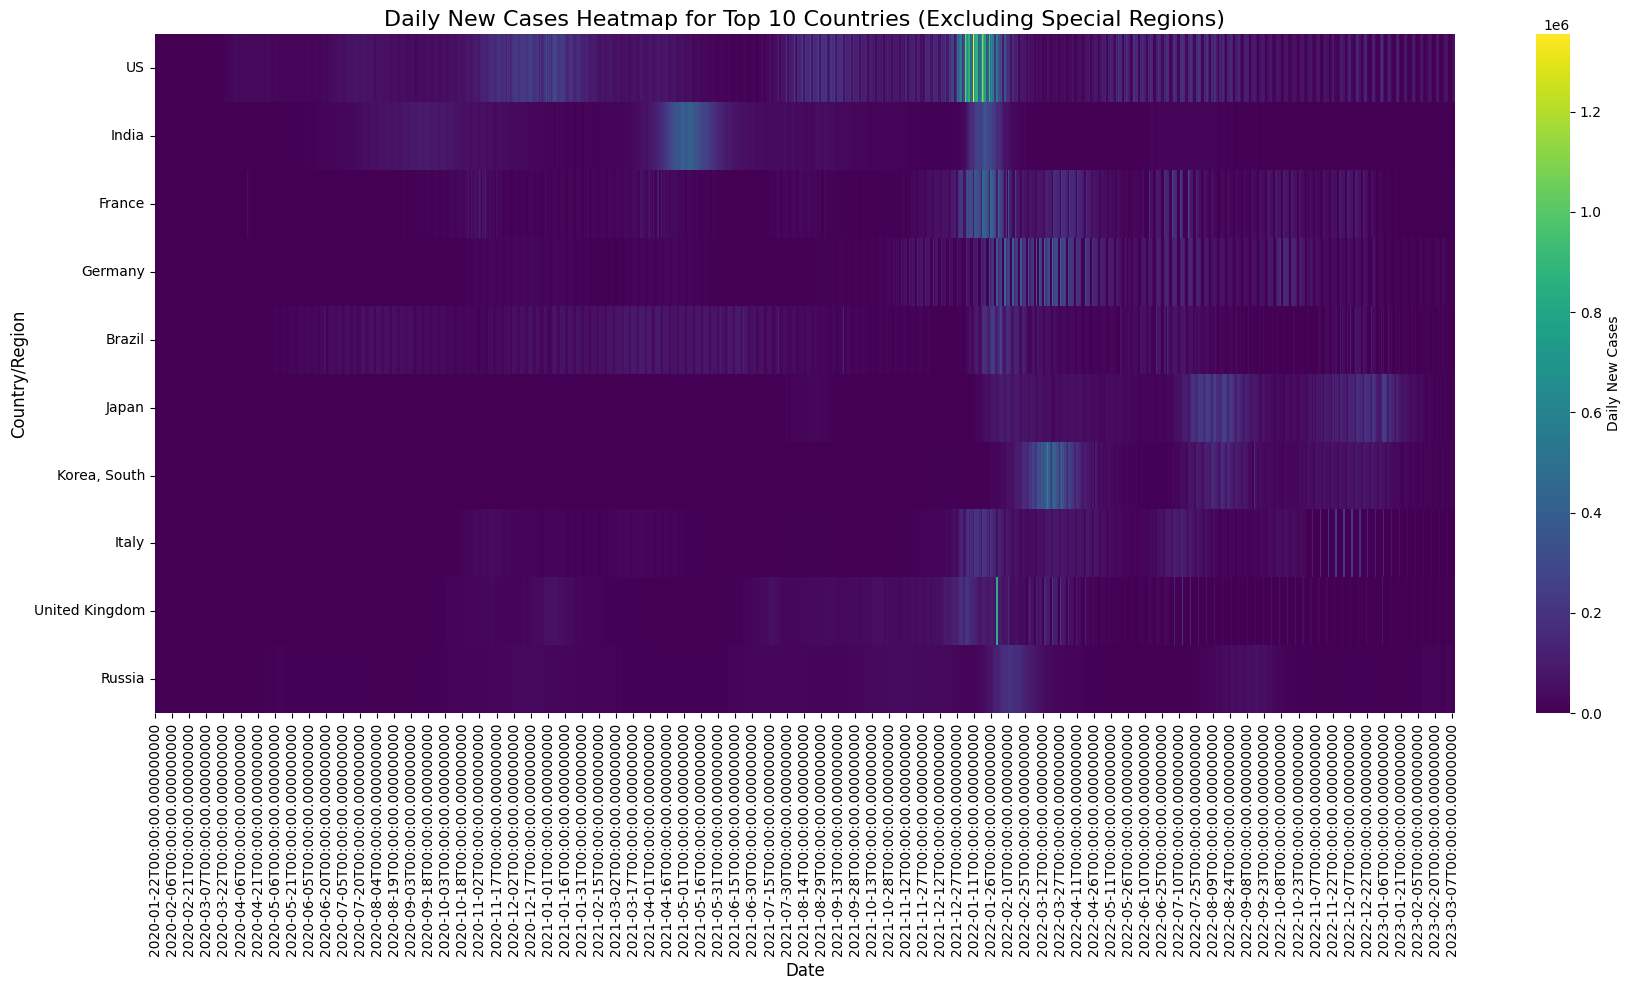

Heatmap generated.

Checking for stationarity using Augmented Dickey-Fuller test (ADF)...

ADF test for original Global Cases:
ADF Statistic: 0.0081
p-value: 0.9592
#Lags Used: 21.0000
Number of Observations Used: 1121.0000
Conclusion: Weak evidence against the null hypothesis (Ho), so the series is non-stationary.

Taking first difference to achieve stationarity (daily new cases)...

ADF test for Differenced Global Cases:
ADF Statistic: -3.0446
p-value: 0.0309
#Lags Used: 20.0000
Number of Observations Used: 1121.0000
Conclusion: Strong evidence against the null hypothesis (Ho), so the series is stationary.

Starting grid search for optimal ARIMA (p,d,q) parameters...
Training data size: 914
Test data size: 229

Grid search complete. Best ARIMANone with AIC: inf


TypeError: cannot unpack non-iterable NoneType object

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Import for potential future use or debugging
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import warnings
import itertools

# Suppress warnings to keep the output clean, especially from statsmodels
warnings.filterwarnings("ignore")

# 1. Load the dataset
print("Loading data...")
try:
    df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
    print("Data loaded successfully.")
except Exception as e:
    print(f"Error loading data: {e}")
    # It's good practice to exit if data loading fails, as subsequent steps depend on it.
    exit()

# 2. Preprocess the data
print("Preprocessing data...")
# Drop unnecessary columns (Lat, Long, Province/State) as they are not needed for global or country-level aggregation
df_processed = df.drop(columns=['Lat', 'Long', 'Province/State'])

# Aggregate by 'Country/Region' to get total cases per country over time
# NaN values in the raw daily case columns are treated as 0 during sum aggregation,
# which is appropriate for cumulative case data where missing implies no cases reported.
df_agg = df_processed.groupby('Country/Region').sum()

# Transpose the dataframe so dates become the index, which is standard for time series analysis
df_ts = df_agg.T

# Convert index to datetime objects for proper time series operations
df_ts.index = pd.to_datetime(df_ts.index)

# Sum across all countries to get the global confirmed cases time series
global_cases = df_ts.sum(axis=1)

# Resample to daily frequency ('D') to ensure continuity and fill any missing dates
# with the last valid observation using forward fill ('ffill'). This is crucial for forecasting.
global_cases = global_cases.asfreq('D')
global_cases = global_cases.fillna(method='ffill')

print("Data preprocessing complete.")
print(f"Time series shape (Global Cases): {global_cases.shape}")
print(f"Time series head (Global Cases):\n{global_cases.head()}")


# --- Generate Heatmap for Top Countries with exclusions ---
print("\nGenerating heatmap for daily new cases of top countries (excluding special regions)...")

# Define a list of non-country/special regions to exclude from the heatmap
# These are typically cruise ships or specific event-related entries that skew country analysis
exclude_regions = [
    'Diamond Princess cruise ship',
    'MS Zaandam',
    'Summer Olympics 2020',
    'Winter Olympics 2022',
    'Grand Princess',
    'Cases on an international conveyance Japan',
    'Canada' # Excluded based on the original user prompt
]

# Filter df_ts to exclude the specified regions before calculating top N countries
# `errors='ignore'` prevents an error if a column from `exclude_regions` isn't found
columns_to_drop = [col for col in exclude_regions if col in df_ts.columns]
df_ts_filtered_for_heatmap = df_ts.drop(columns=columns_to_drop, errors='ignore')

# Calculate total cases for each country (excluding special regions) to find the top N
# Use the last row (most recent total cases) to rank countries
country_total_cases = df_ts_filtered_for_heatmap.iloc[-1].sort_values(ascending=False)
top_n_countries = country_total_cases.head(10).index.tolist() # Get the names of the top 10 countries

# Filter df_ts_filtered_for_heatmap for these top countries for further analysis
df_top_countries = df_ts_filtered_for_heatmap[top_n_countries]

# Calculate daily new cases for selected countries by taking the difference between consecutive days.
# `fillna(0)` handles the first row (which becomes NaN after diff), and `clip(lower=0)` ensures no negative values.
daily_new_cases_top_countries = df_top_countries.diff().fillna(0).clip(lower=0)

# Create the heatmap
plt.figure(figsize=(18, 10)) # Adjust figure size for better readability
sns.heatmap(daily_new_cases_top_countries.T, cmap='viridis', cbar_kws={'label': 'Daily New Cases'})
plt.title('Daily New Cases Heatmap for Top 10 Countries (Excluding Special Regions)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Country/Region', fontsize=12)
plt.yticks(rotation=0) # Ensure country names are horizontal
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

print("Heatmap generated.")
# --- End of Heatmap addition ---


# 3. Check for stationarity and difference the data if necessary
print("\nChecking for stationarity using Augmented Dickey-Fuller test (ADF)...")
def adf_test(series):
    """
    Performs the Augmented Dickey-Fuller test on a time series
    to check for stationarity.
    """
    result = adfuller(series.dropna()) # .dropna() handles any initial NaNs
    labels = ['ADF Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(f'{label}: {value:.4f}') # Format to 4 decimal places for clarity
    if result[1] <= 0.05: # p-value <= 0.05 indicates stationarity
        print("Conclusion: Strong evidence against the null hypothesis (Ho), so the series is stationary.")
    else:
        print("Conclusion: Weak evidence against the null hypothesis (Ho), so the series is non-stationary.")

# Test stationarity for the original global cases data
print("\nADF test for original Global Cases:")
adf_test(global_cases)

print("\nTaking first difference to achieve stationarity (daily new cases)...")
# The first difference represents daily new cases.
# .dropna() removes the first NaN created by diff().
# .clip(lower=0) ensures non-negative daily new cases.
global_cases_diff = global_cases.diff().dropna().clip(lower=0)

# Test stationarity for the differenced global cases data
print("\nADF test for Differenced Global Cases:")
adf_test(global_cases_diff)

# 4. Determine the ARIMA model orders (p, d, q) through grid search
print("\nStarting grid search for optimal ARIMA (p,d,q) parameters...")

# Define the ranges for p, d, q parameters to try
# p: auto-regressive (AR) order
# d: integrated (I) order (number of differencing operations)
# q: moving average (MA) order
p_values = range(0, 5) # p can be 0, 1, 2 (adjusted range to speed up and commonly effective values)
d_values = range(0, 5) # d can be 0, 1 (as we likely need 1 differencing for stationarity)
q_values = range(0, ) # q can be 0, 1, 2 (adjusted range)

# Generate all different combinations of p, d, q
pdq_combinations = list(itertools.product(p_values, d_values, q_values))

best_aic = float("inf") # Initialize with a very large value to find the minimum AIC
best_pdq = None
best_model_fit = None # Store the best fitted model to avoid refitting

# Split data into training (80%) and testing (20%) sets for model validation during grid search
train_size = int(len(global_cases) * 0.8)
train_data, test_data = global_cases[0:train_size], global_cases[train_size:]

print(f"Training data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")

# Iterate over all possible (p, d, q) combinations
for order in pdq_combinations:
    try:
        # Fit ARIMA model on the training data with the current order
        model = ARIMA(train_data, order=order)
        model_fit = model.fit()

        # Check if the current model's AIC is better than the best found so far
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_pdq = order
            best_model_fit = model_fit # Update the best fitted model
        # Uncomment the line below to see AIC for each combination during search
        # print(f'ARIMA{order} AIC: {model_fit.aic:.2f}')
    except Exception as e:
        # print(f'ARIMA{order} failed: {e}') # Uncomment for detailed errors during search
        continue # Continue to the next combination if fitting fails

print(f"\nGrid search complete. Best ARIMA{best_pdq} with AIC: {best_aic:.2f}")

# Use the best parameters found from the grid search
p, d, q = best_pdq
print(f"\nUsing optimal ARIMA({p},{d},{q}) model for final forecast.")

# 5. Fit the ARIMA model with optimal parameters
print("Fitting ARIMA model with optimal parameters on the training data...")
try:
    # Use the best_model_fit already obtained from the grid search.
    # This avoids refitting the same model if it was successfully found.
    if best_model_fit is None: # Fallback in case no model could be fitted during grid search
        model = ARIMA(train_data, order=(p, d, q))
        model_fit = model.fit()
    else:
        model_fit = best_model_fit # Use the pre-fitted best model

    print("ARIMA model fitted successfully with optimal parameters.")
    # Display the summary of the fitted model for detailed statistics
    print(model_fit.summary())
except Exception as e:
    print(f"Error fitting ARIMA model with optimal parameters: {e}")
    print("Consider adjusting p, d, q values or simplifying the model configuration.")
    exit() # Exit if final model fitting fails, as predictions depend on it.

# 6. Make predictions on the test set
print("\nMaking predictions...")
# Define the start and end indices for the forecast based on the training and global data length
start_forecast = len(train_data)
end_forecast = len(global_cases) - 1 # Last index of the original global cases data

# Generate predictions using the fitted model
# `dynamic=False` means predictions for each step use actual values up to the previous step.
# If `dynamic=True`, predictions for each step use previous *forecasted* values.
forecast = model_fit.predict(start=start_forecast, end=end_forecast, dynamic=False)

# Assign the index of the test_data to the forecast for proper plotting alignment
forecast.index = test_data.index
# Ensure no negative forecasted cases, as case counts cannot be negative
forecast[forecast < 0] = 0

print("Predictions generated.")
print(f"Forecasted values head:\n{forecast.head()}")

# 7. Evaluate performance with Mean Squared Error (MSE)
print("\nEvaluating model performance...")
# Align actual values with the forecast's index to ensure correct comparison
actual_values = test_data.loc[forecast.index]
mse = mean_squared_error(actual_values, forecast)
print(f"Mean Squared Error (MSE) on the test set: {mse:.2f}")

# 8. Visualize the results
print("\nVisualizing actual vs. forecasted values...")
plt.figure(figsize=(15, 7)) # Set figure size for better visualization
plt.plot(train_data.index, train_data, label='Training Data (Actual Cases)', color='blue')
plt.plot(test_data.index, test_data, label='Actual Cases (Test Data)', color='green')
plt.plot(forecast.index, forecast, label='ARIMA Forecast', color='red', linestyle='--')
plt.title('ARIMA Forecast vs. Actual Global Confirmed COVID-19 Cases', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Confirmed Cases', fontsize=12)
plt.legend(fontsize=10) # Add legend for clarity
plt.grid(True) # Add grid for easier reading of values
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

print("\nARIMA forecasting complete. The plot shows the training data, actual test data, and the ARIMA forecast.")
print(f"The Mean Squared Error (MSE) on the test set is: {mse:.2f}")


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Load the dataset
df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

# Aggregate global confirmed cases
# Drop unnecessary columns and sum across countries for each date
df_time_series = df.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long']).sum().reset_index()
df_time_series.columns = ['Date', 'ConfirmedCases']

# Convert 'Date' to datetime and set as index
df_time_series['Date'] = pd.to_datetime(df_time_series['Date'])
df_time_series = df_time_series.set_index('Date')

# Calculate daily new cases instead of cumulative cases for better stationarity
# Cumulative data often has a strong trend, making it non-stationary.
# Differencing once will give daily new cases, which might be more suitable for ARIMA.
df_time_series['DailyNewCases'] = df_time_series['ConfirmedCases'].diff().fillna(0) # Fill NaN from diff with 0

# It's better to work with daily new cases if you want to model short-term fluctuations
# If you want to model the cumulative trend, you'll likely need more differencing.
# For this example, let's stick with DailyNewCases
time_series_data = df_time_series['DailyNewCases']

# You might want to remove initial zeros if they are just reporting zeros
# time_series_data = time_series_data[time_series_data > 0] # Be careful with this, check your data first

ADF test for Daily New Cases:
ADF Statistic: -3.043423
p-value: 0.031033
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


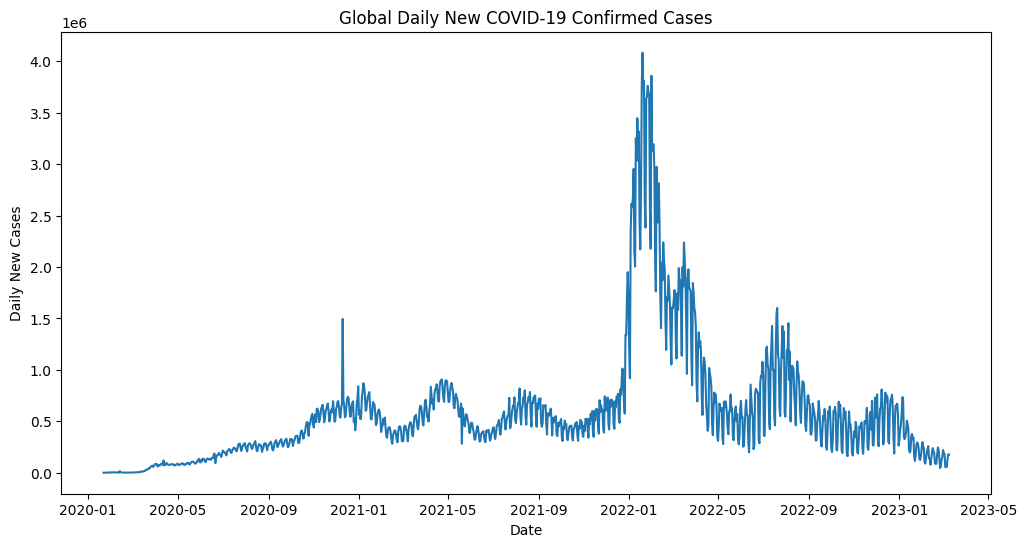

In [3]:
# Perform ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

print("ADF test for Daily New Cases:")
adf_test(time_series_data)

# Plot to visually inspect
plt.figure(figsize=(12, 6))
plt.plot(time_series_data)
plt.title('Global Daily New COVID-19 Confirmed Cases')
plt.xlabel('Date')
plt.ylabel('Daily New Cases')
plt.show()

# If p-value is > 0.05, the series is likely non-stationary and needs differencing.
# The 'd' parameter in ARIMA(p,d,q) handles this differencing.
# We already did one differencing to get DailyNewCases.
# If 'DailyNewCases' is still non-stationary, you might need to difference it again (d=2 in ARIMA).

In [ ]:
# Plot ACF and PACF to determine p and q
plt.figure(figsize=(12, 8))
plt.subplot(211)
plot_acf(time_series_data.dropna(), ax=plt.gca(), lags=50) # dropna() because diff creates NaN
plt.title('Autocorrelation Function (ACF) for Daily New Cases')

plt.subplot(212)
plot_pacf(time_series_data.dropna(), ax=plt.gca(), lags=50)
plt.title('Partial Autocorrelation Function (PACF) for Daily New Cases')
plt.tight_layout()
plt.show()

# Based on ACF/PACF plots, you'll choose initial p and q values.
# For example, if ACF trails off and PACF cuts off after lag 2, it suggests AR(2), so p=2.
# If PACF trails off and ACF cuts off after lag 1, it suggests MA(1), so q=1.
# Often, for real-world data, this isn't perfectly clear, and you might need to try a few combinations.

# A common approach is to use auto_arima from the pmdarima library, which automatically finds the best p, d, q.
# If you don't have it, install it: pip install pmdarima
from pmdarima import auto_arima

# This can take a while to run
# model_auto_arima = auto_arima(time_series_data,
#                               seasonal=False, # Set to True if you suspect seasonality (e.g., weekly patterns)
#                               suppress_warnings=True,
#                               stepwise=True)
# print(model_auto_arima.summary())
# You would get the optimal (p,d,q) from this output.
# For COVID data, there might be strong seasonality (e.g., weekly reporting patterns), so seasonal=True
# might be beneficial, leading to a SARIMA model.

                               SARIMAX Results                                
Dep. Variable:          DailyNewCases   No. Observations:                  914
Model:                 ARIMA(2, 2, 4)   Log Likelihood              -12410.985
Date:                Mon, 14 Jul 2025   AIC                          24835.969
Time:                        12:40:30   BIC                          24869.679
Sample:                    01-22-2020   HQIC                         24848.838
                         - 07-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1600      0.026     -6.165      0.000      -0.211      -0.109
ar.L2         -0.7725      0.022    -35.744      0.000      -0.815      -0.730
ma.L1         -0.8552      0.035    -24.150      0.0

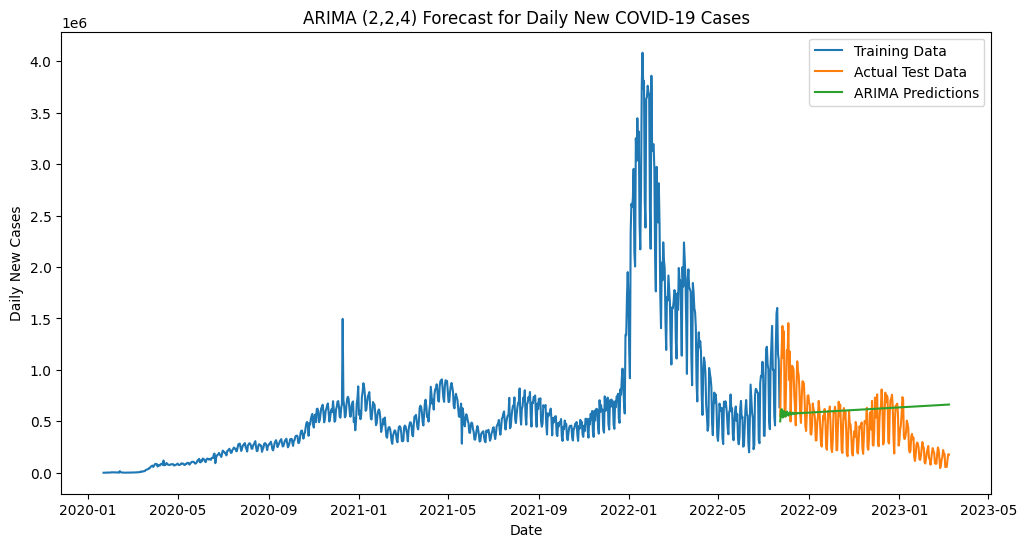

RMSE: 332173.146
MAE: 271890.513


In [4]:
# Split data into training and testing sets (optional but highly recommended)
train_size = int(len(time_series_data) * 0.8)
train_data, test_data = time_series_data[0:train_size], time_series_data[train_size:]

# Fit the ARIMA model
# Replace p, d, q with your determined orders
# Let's use (5,0,5) as a placeholder. You'll need to optimize this.
# For cumulative data, a common starting point might be (5,1,0) or (1,1,0)
# For daily new cases, 'd' is often 0 if you've already differenced.
order = (2, 2, 4) # Example orders, you need to determine this based on analysis

try:
    model = ARIMA(train_data.dropna(), order=order) # dropna() is crucial here
    model_fit = model.fit()
    print(model_fit.summary())

    # Make predictions
    start_index = len(train_data)
    end_index = len(time_series_data) - 1
    predictions = model_fit.predict(start=start_index, end=end_index)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data, label='Training Data')
    plt.plot(test_data.index, test_data, label='Actual Test Data')
    plt.plot(predictions.index, predictions, label='ARIMA Predictions')
    plt.title(f'ARIMA ({order[0]},{order[1]},{order[2]}) Forecast for Daily New COVID-19 Cases')
    plt.xlabel('Date')
    plt.ylabel('Daily New Cases')
    plt.legend()
    plt.show()

    # Evaluate the model (e.g., using Mean Squared Error or Mean Absolute Error)
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    rmse = np.sqrt(mean_squared_error(test_data, predictions))
    mae = mean_absolute_error(test_data, predictions)
    print(f'RMSE: {rmse:.3f}')
    print(f'MAE: {mae:.3f}')

except Exception as e:
    print(f"An error occurred during ARIMA model fitting or prediction: {e}")
    print("Consider adjusting the ARIMA (p,d,q) orders or checking data stationarity.")

X_train shape: (903, 14, 1)
y_train shape: (903,)
X_test shape: (226, 14, 1)
y_test shape: (226,)
Epoch 1/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - loss: 0.0198 - val_loss: 0.0042
Epoch 2/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 3/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 4/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 5/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 6/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0037 - val_loss: 0.0044
Epoch 7/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 8/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 9/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 10/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0032 - val_loss: 0.0043
Epoch 11/300
26/26 ━━━━━━━━━━━━━━━━━━━━

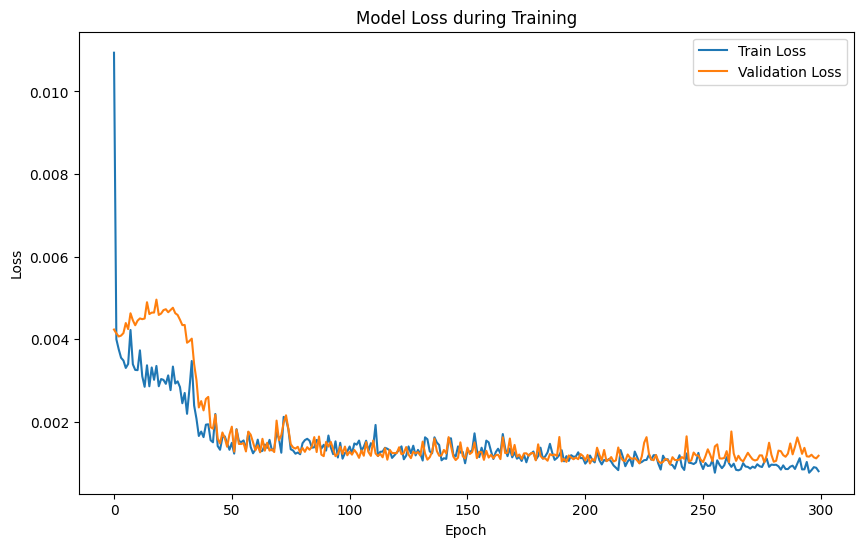

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Root Mean Squared Error (RMSE): 99788.10
Mean Absolute Error (MAE): 72126.64


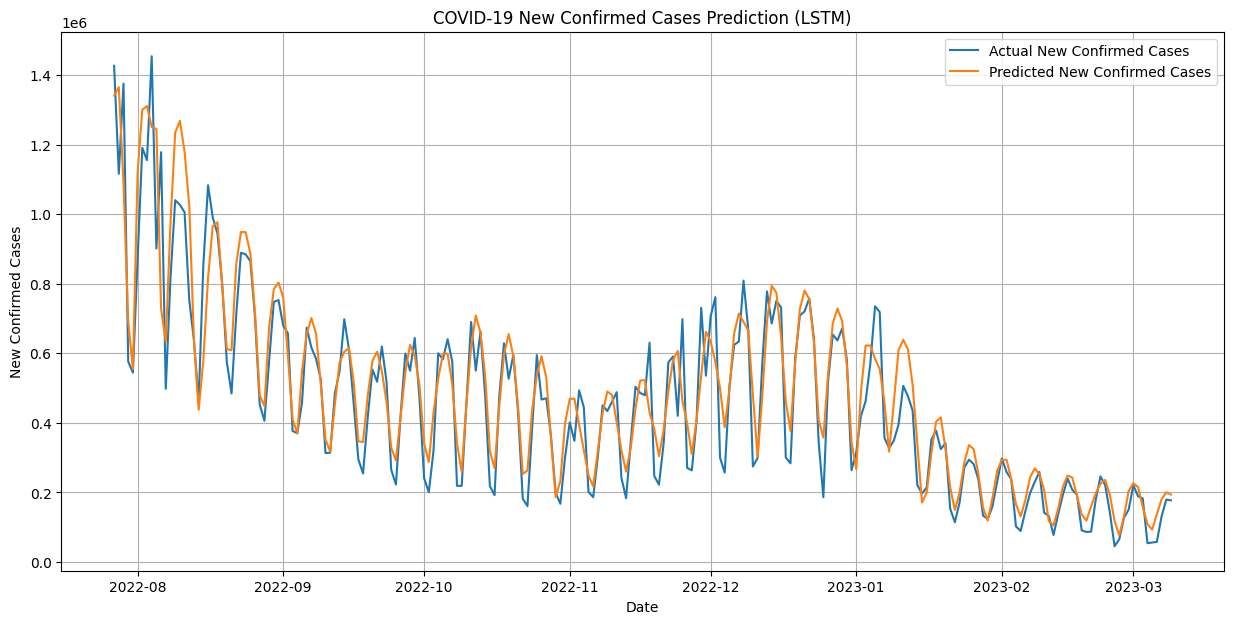

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted new confirmed cases for the next day: 150500


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
import math

# URL of the dataset
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

# 1. Data Loading and Preprocessing
df = pd.read_csv(url)

# Let's focus on global confirmed cases for simplicity, summing up all provinces/states
# We need to drop 'Province/State', 'Country/Region', 'Lat', 'Long' to get only date columns
df_time_series = df.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long']).sum(axis=0)
df_time_series = pd.DataFrame(df_time_series, columns=['Confirmed'])
df_time_series.index = pd.to_datetime(df_time_series.index)

# Calculate daily new confirmed cases (often better for forecasting than cumulative)
df_time_series['New_Confirmed'] = df_time_series['Confirmed'].diff().fillna(0)
# Ensure no negative new cases (can happen due to data corrections)
df_time_series['New_Confirmed'] = df_time_series['New_Confirmed'].apply(lambda x: max(0, x))

# Use 'New_Confirmed' for forecasting
data = df_time_series['New_Confirmed'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 2. Create Sequences for LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        # Extract the sequence of n_steps
        seq_x = data[i:(i + n_steps), 0]
        # The target is the next value after the sequence
        seq_y = data[i + n_steps, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 14 # Number of previous time steps to use as input

X, y = create_sequences(scaled_data, n_steps)

# Reshape X for LSTM input (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# 3. Split Data into Training and Testing Sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# 4. Build the LSTM Model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(n_steps, 1))) # First LSTM layer
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False)) # Second LSTM layer
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Output layer

# 5. Compile and Train the Model
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_split=0.1, verbose=1)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 6. Make Predictions and Evaluate
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
rmse = math.sqrt(mean_squared_error(y_test_original, predictions))
mae = mean_absolute_error(y_test_original, predictions)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Visualize actual vs. predicted (on the test set)
plt.figure(figsize=(15, 7))
plt.plot(df_time_series.index[train_size + n_steps:], y_test_original, label='Actual New Confirmed Cases')
plt.plot(df_time_series.index[train_size + n_steps:], predictions, label='Predicted New Confirmed Cases')
plt.title('COVID-19 New Confirmed Cases Prediction (LSTM)')
plt.xlabel('Date')
plt.ylabel('New Confirmed Cases')
plt.legend()
plt.grid(True)
plt.show()

# Example of forecasting future values (one step ahead)
# Get the last 'n_steps' values from the original scaled data
last_n_steps = scaled_data[-n_steps:]
last_n_steps = last_n_steps.reshape(1, n_steps, 1)

# Predict the next day
next_day_prediction_scaled = model.predict(last_n_steps)
next_day_prediction_original = scaler.inverse_transform(next_day_prediction_scaled)

print(f"Predicted new confirmed cases for the next day: {next_day_prediction_original[0][0]:.0f}")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import math

# Load dataset
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df = pd.read_csv(url)

# Preprocess: sum across all countries to get global total
df_time_series = df.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long']).sum(axis=0)
df_time_series = pd.DataFrame(df_time_series, columns=['Confirmed'])
df_time_series.index = pd.to_datetime(df_time_series.index)

# Calculate new daily confirmed cases
df_time_series['New_Confirmed'] = df_time_series['Confirmed'].diff().fillna(0)
df_time_series['New_Confirmed'] = df_time_series['New_Confirmed'].apply(lambda x: max(0, x))

# Smooth the data with 7-day moving average
df_time_series['Smoothed'] = df_time_series['New_Confirmed'].rolling(7).mean().fillna(method='bfill')

# Log transform to reduce scale volatility
df_time_series['Log_Smoothed'] = np.log1p(df_time_series['Smoothed'])

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_time_series['Log_Smoothed'].values.reshape(-1, 1))

# Create sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps, 0])
        y.append(data[i+n_steps, 0])
    return np.array(X), np.array(y)

n_steps = 7
X, y = create_sequences(scaled_data, n_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(n_steps, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=365, batch_size=32,
                    validation_split=0.1, callbacks=[early_stop], verbose=1)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
predictions_scaled = model.predict(X_test)

# Inverse transform (log1p + scaler)
predictions = np.expm1(scaler.inverse_transform(predictions_scaled))
y_test_original = np.expm1(scaler.inverse_transform(y_test.reshape(-1, 1)))

# Evaluation metrics
rmse = math.sqrt(mean_squared_error(y_test_original, predictions))
mae = mean_absolute_error(y_test_original, predictions)
mape = np.mean(np.abs((y_test_original - predictions) / y_test_original)) * 100

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Visualize predictions
test_dates = df_time_series.index[n_steps + train_size:]
plt.figure(figsize=(15, 7))
plt.plot(test_dates, y_test_original, label='Actual New Cases')
plt.plot(test_dates, predictions, label='Predicted New Cases')
plt.title('COVID-19 New Confirmed Cases Forecast (LSTM)')
plt.xlabel('Date')
plt.ylabel('New Confirmed Cases')
plt.legend()
plt.grid(True)
plt.show()

# Forecast next day
last_n_steps = scaled_data[-n_steps:].reshape(1, n_steps, 1)
next_day_scaled = model.predict(last_n_steps)
next_day = np.expm1(scaler.inverse_transform(next_day_scaled))
print(f"Predicted new confirmed cases for next day: {next_day[0][0]:.0f}")



In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df_time_series['New_Confirmed'], label='Daily New Cases')
plt.title("Daily New COVID-19 Cases")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.grid(True)
plt.show()


Epoch 0 | Train Loss: 0.448504 | Val Loss: 0.198958
Epoch 1 | Train Loss: 0.209326 | Val Loss: 0.005478
Epoch 2 | Train Loss: 0.022278 | Val Loss: 0.540000
Epoch 3 | Train Loss: 0.561352 | Val Loss: 0.033884
Epoch 4 | Train Loss: 0.053118 | Val Loss: 0.026784
Epoch 5 | Train Loss: 0.042601 | Val Loss: 0.082462
Epoch 6 | Train Loss: 0.096287 | Val Loss: 0.109271
Epoch 7 | Train Loss: 0.122338 | Val Loss: 0.113504
Epoch 8 | Train Loss: 0.126503 | Val Loss: 0.104039
Epoch 9 | Train Loss: 0.117391 | Val Loss: 0.086396
Epoch 10 | Train Loss: 0.100395 | Val Loss: 0.064263
Epoch 11 | Train Loss: 0.079151 | Val Loss: 0.040893
Epoch 12 | Train Loss: 0.056882 | Val Loss: 0.020001
Epoch 13 | Train Loss: 0.037279 | Val Loss: 0.006192
Epoch 14 | Train Loss: 0.024891 | Val Loss: 0.004519
Epoch 15 | Train Loss: 0.024645 | Val Loss: 0.014644
Epoch 16 | Train Loss: 0.035887 | Val Loss: 0.021147
Epoch 17 | Train Loss: 0.042953 | Val Loss: 0.018583
Epoch 18 | Train Loss: 0.040465 | Val Loss: 0.012293
Epo

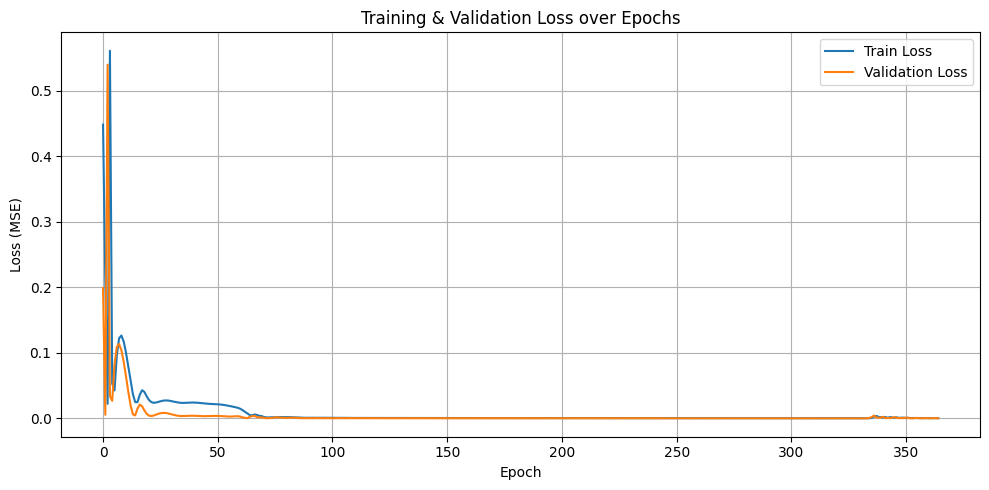

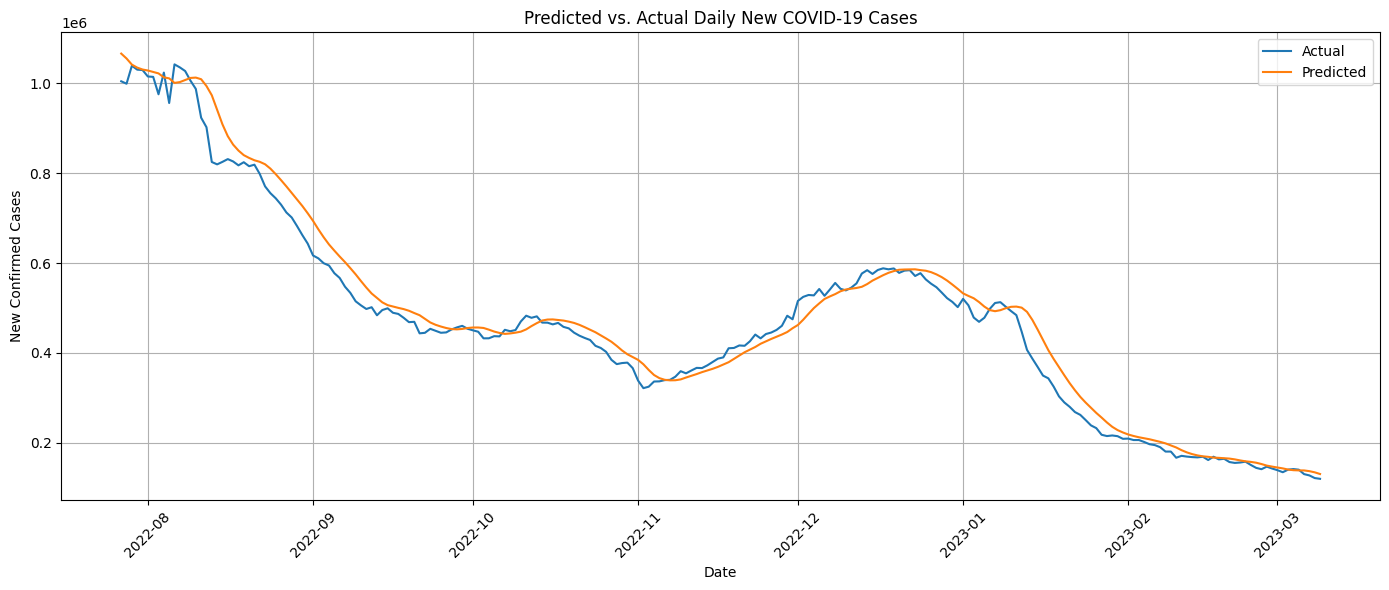

✅ Quantized model saved as 'quantized_lstm_forecaster.pth'


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# ------------------------ 1. Load & Preprocess Data ------------------------ #
# Load COVID-19 data
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df = pd.read_csv(url)

# Aggregate global daily confirmed cases
df_time_series = df.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long']).sum(axis=0)
df_time_series = pd.DataFrame(df_time_series, columns=['Confirmed'])
df_time_series.index = pd.to_datetime(df_time_series.index)

# Compute new daily cases
df_time_series['New_Confirmed'] = df_time_series['Confirmed'].diff().fillna(0)
df_time_series['New_Confirmed'] = df_time_series['New_Confirmed'].apply(lambda x: max(0, x))

# Apply 7-day moving average smoothing
df_time_series['Smoothed'] = df_time_series['New_Confirmed'].rolling(window=7).mean().fillna(method='bfill')

# Log transform
df_time_series['Log_Smoothed'] = np.log1p(df_time_series['Smoothed'])

# Scale
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_time_series['Log_Smoothed'].values.reshape(-1, 1)).flatten()

# ------------------------ 2. Sequence Creation ------------------------ #
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 14
X, y = create_sequences(scaled_data, n_steps)

# Train/test split
train_size = int(len(X) * 0.8)
X_train = torch.tensor(X[:train_size], dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y[:train_size], dtype=torch.float32)
X_test = torch.tensor(X[train_size:], dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y[train_size:], dtype=torch.float32)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

# ------------------------ 3. LSTM Model Definition ------------------------ #
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# ------------------------ 4. Training Loop ------------------------ #
train_losses, val_losses = [], []
epochs = 365

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(X_train).squeeze()
    loss = criterion(pred, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_pred = model(X_test).squeeze()
        val_loss = criterion(val_pred, y_test)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 1 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.6f} | Val Loss: {val_loss.item():.6f}")

# ------------------------ 5. Evaluation ------------------------ #
model.eval()
with torch.no_grad():
    predictions = model(X_test).squeeze().cpu().numpy()
    true_values = y_test.cpu().numpy()

# Inverse transform
predictions = np.expm1(scaler.inverse_transform(predictions.reshape(-1, 1)))
true_values = np.expm1(scaler.inverse_transform(true_values.reshape(-1, 1)))

rmse = math.sqrt(mean_squared_error(true_values, predictions))
mae = mean_absolute_error(true_values, predictions)
mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100

print(f"\n✅ Evaluation Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# ------------------------ 6. Plots ------------------------ #
# Loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training & Validation Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Actual vs. Predicted
test_dates = df_time_series.index[n_steps + train_size:]

plt.figure(figsize=(14, 6))
plt.plot(test_dates, true_values, label='Actual')
plt.plot(test_dates, predictions, label='Predicted')
plt.title('Predicted vs. Actual Daily New COVID-19 Cases')
plt.xlabel('Date')
plt.ylabel('New Confirmed Cases')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------ 7. Quantization ------------------------ #
model_cpu = model.to('cpu')
quantized_model = torch.quantization.quantize_dynamic(
    model_cpu, {nn.LSTM, nn.Linear}, dtype=torch.qint8
)

torch.save(quantized_model.state_dict(), "quantized_lstm_forecaster.pth")
print("✅ Quantized model saved as 'quantized_lstm_forecaster.pth'")


--- GPU Configuration ---
No GPU devices found. TensorFlow will use CPU.
------------------------

Data prepared: Train samples: 903, Test samples: 226
LSTM input shape: (14, 1)

Building and training LSTM model with fixed parameters...
Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.1914 - val_loss: 0.0084
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0091 - val_loss: 3.4552e-04
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0046 - val_loss: 2.6790e-04
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0036 - val_loss: 4.0669e-04
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0039 - val_loss: 2.3974e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0034 - val_loss: 3.8954e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0033 - val_loss: 1.9199e-04
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0028 - val_loss: 3.9913e-04
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/

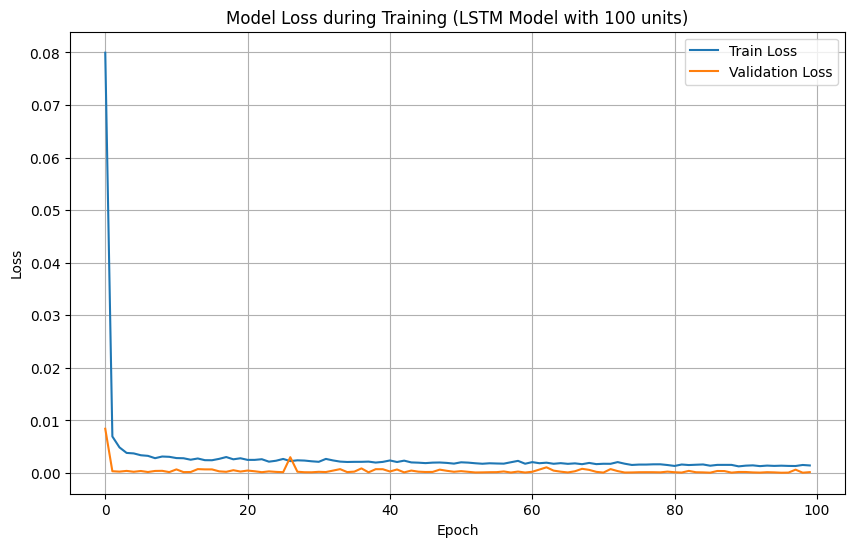

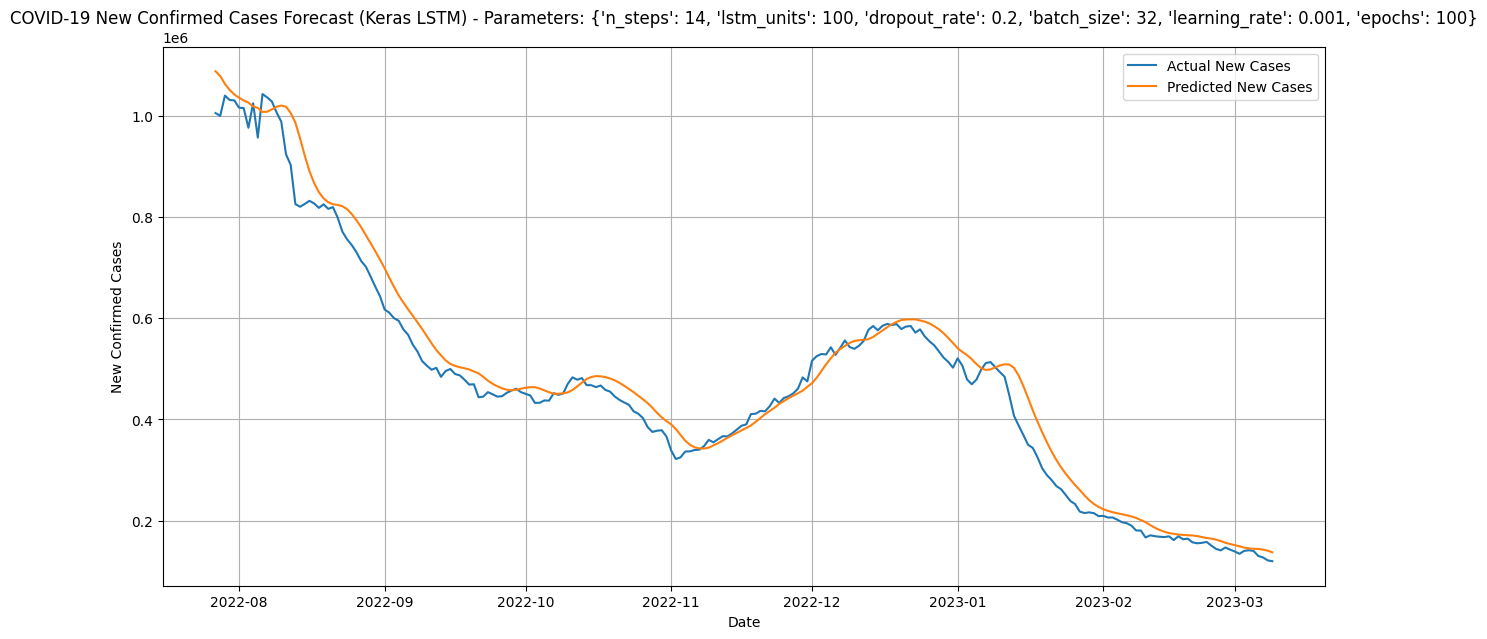

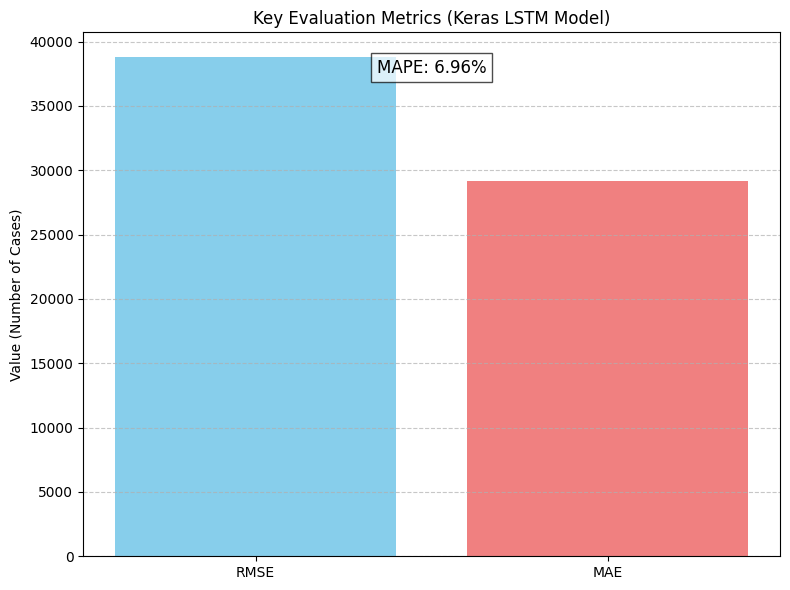


Forecasting next day using the trained model...
Predicted new confirmed cases for next day: 133839

--- Applying Quantization ---
Saved artifact at 'keras_lstm_model_original_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 14, 1), dtype=tf.float32, name='keras_tensor_16')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132741484550416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132741484552336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132741484552912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132741484553104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132741484554256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132741484554832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132741484554448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132741484555600: TensorSpec(shape=(), dtype=tf.resource, name=None)
Original

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import math
import warnings
import tensorflow as tf # Import TensorFlow
import os # For file operations

warnings.filterwarnings("ignore")

# ------------------------ GPU Configuration ------------------------ #
print("--- GPU Configuration ---")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs configured.")
        print("TensorFlow will attempt to use GPU(s) if available.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU devices found. TensorFlow will use CPU.")
print("------------------------\n")

# ------------------------ 1. Load & Preprocess Data ------------------------ #
# Load dataset
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df = pd.read_csv(url)

# Preprocess: sum across all countries to get global total
df_time_series = df.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long']).sum(axis=0)
df_time_series = pd.DataFrame(df_time_series, columns=['Confirmed'])
df_time_series.index = pd.to_datetime(df_time_series.index)

# Calculate new daily confirmed cases
df_time_series['New_Confirmed'] = df_time_series['Confirmed'].diff().fillna(0)
df_time_series['New_Confirmed'] = df_time_series['New_Confirmed'].apply(lambda x: max(0, x))

# Smooth the data with 7-day moving average
df_time_series['Smoothed'] = df_time_series['New_Confirmed'].rolling(7).mean().fillna(method='bfill')
df_time_series['Smoothed'] = df_time_series['Smoothed'].fillna(method='ffill') # Ensure no NaNs remain

# Log transform to reduce scale volatility
df_time_series['Log_Smoothed'] = np.log1p(df_time_series['Smoothed'])

# Scale data
scaler = MinMaxScaler()
# Reshape for scaler as fit_transform expects 2D array, then flatten for create_sequences
scaled_data = scaler.fit_transform(df_time_series['Log_Smoothed'].values.reshape(-1, 1)) # Keep 2D for create_sequences

# Create sequences function
def create_sequences(data, n_steps):
    """
    Creates sequences of data for LSTM input.
    X: sequences of 'n_steps' values
    y: the value immediately following the sequence
    Data should be 2D: (samples, features)
    """
    X, y = [], []
    for i in range(len(data) - n_steps):
        # Data here is 2D, so access the first (and only) feature
        X.append(data[i:i+n_steps, 0])
        y.append(data[i+n_steps, 0])
    return np.array(X), np.array(y)

# ------------------------ 2. Define Fixed Model Parameters ------------------------ #
# These parameters are now fixed, no tuning will be performed.
# You can adjust these values manually to experiment.
fixed_params = {
    'n_steps': 14,          # Look-back window size
    'lstm_units': 100,      # Number of LSTM units in each layer
    'dropout_rate': 0.2,    # Dropout rate
    'batch_size': 32,       # Training batch size
    'learning_rate': 0.001, # Learning rate for Adam optimizer
    'epochs': 100           # Number of training epochs (EarlyStopping will typically halt sooner)
}

n_steps = fixed_params['n_steps'] # Define n_steps in global scope for plots
lstm_units = fixed_params['lstm_units']
dropout_rate = fixed_params['dropout_rate']
batch_size = fixed_params['batch_size']
learning_rate = fixed_params['learning_rate']
epochs = fixed_params['epochs']


# ------------------------ 3. Create Sequences and Split Data ------------------------ #
X, y = create_sequences(scaled_data, n_steps)
X = X.reshape((X.shape[0], X.shape[1], 1)) # Reshape for LSTM input (samples, timesteps, features)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Data prepared: Train samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"LSTM input shape: {X_train.shape[1:]}") # Should be (n_steps, 1)

# ------------------------ 4. Build and Train LSTM Model ------------------------ #
print("\nBuilding and training LSTM model with fixed parameters...")
model = Sequential()
model.add(LSTM(lstm_units, return_sequences=True, input_shape=(n_steps, 1)))
model.add(Dropout(dropout_rate))
model.add(LSTM(lstm_units))
model.add(Dropout(dropout_rate))
model.add(Dense(1))

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

history = model.fit(X_train, y_train, epochs=epochs,
                    batch_size=batch_size, validation_split=0.1,
                    callbacks=[early_stop], verbose=1)

print("Model training complete.")

# ------------------------ 5. Make Predictions and Inverse Transform ------------------------ #
print("\nMaking predictions on the test set...")
predictions_scaled = model.predict(X_test, verbose=0)

# Inverse transform predictions and actual values back to original scale
predictions = np.expm1(scaler.inverse_transform(predictions_scaled))
y_test_original = np.expm1(scaler.inverse_transform(y_test.reshape(-1, 1)))

# Ensure predictions are non-negative
predictions[predictions < 0] = 0

# ------------------------ 6. Evaluation Metrics ------------------------ #
rmse = math.sqrt(mean_squared_error(y_test_original, predictions))
mae = mean_absolute_error(y_test_original, predictions)

valid_indices_mape = y_test_original > 1e-8
if np.any(valid_indices_mape):
    mape = np.mean(np.abs((y_test_original[valid_indices_mape] - predictions[valid_indices_mape]) / y_test_original[valid_indices_mape])) * 100
else:
    mape = float('inf')

print(f"\n✅ Evaluation Metrics (Keras LSTM Model):")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# ------------------------ 7. Plots ------------------------ #
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Model Loss during Training (LSTM Model with {lstm_units} units)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Visualize predictions
test_start_idx_in_original_series = len(df_time_series.index) - len(y_test_original)
test_dates = df_time_series.index[test_start_idx_in_original_series:]

plt.figure(figsize=(15, 7))
plt.plot(test_dates, y_test_original, label='Actual New Cases')
plt.plot(test_dates, predictions, label='Predicted New Cases')
plt.title(f'COVID-19 New Confirmed Cases Forecast (Keras LSTM) - Parameters: {fixed_params}')
plt.xlabel('Date')
plt.ylabel('New Confirmed Cases')
plt.legend()
plt.grid(True)
plt.show()

# Plot All Evaluation Measures
plt.figure(figsize=(8, 6))
metrics_labels = ['RMSE', 'MAE']
metrics_values = [rmse, mae]

x = np.arange(len(metrics_labels))
plt.bar(x, metrics_values, color=['skyblue', 'lightcoral'])
plt.xticks(x, metrics_labels)
plt.ylabel('Value (Number of Cases)')
plt.title('Key Evaluation Metrics (Keras LSTM Model)')

plt.text(0.5, 0.95, f'MAPE: {mape:.2f}%', horizontalalignment='center', verticalalignment='top',
         transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ------------------------ 8. Forecast Next Day ------------------------ #
print("\nForecasting next day using the trained model...")
final_n_steps = fixed_params['n_steps']

last_n_steps_sequence = scaled_data[-final_n_steps:].reshape(1, final_n_steps, 1)

next_day_scaled = model.predict(last_n_steps_sequence, verbose=0)

next_day_forecast = np.expm1(scaler.inverse_transform(next_day_scaled))
next_day_forecast = max(0, next_day_forecast[0][0])

print(f"Predicted new confirmed cases for next day: {next_day_forecast:.0f}")

# ------------------------ 9. Quantization and Memory Reduction ------------------------ #
print("\n--- Applying Quantization ---")
# Changed to a directory for SavedModel format
original_model_dir = "keras_lstm_model_original_savedmodel"
quantized_model_path = "keras_lstm_model_quantized.tflite"

# Save the original Keras model in SavedModel format
try:
    # Use model.export for SavedModel format (recommended for TFLite conversion)
    model.export(original_model_dir)
    # Calculate size of the directory
    original_size_bytes = sum(os.path.getsize(os.path.join(dirpath, filename)) for dirpath, dirnames, filenames in os.walk(original_model_dir) for filename in filenames)
    print(f"Original Keras model saved to '{original_model_dir}' directory. Size: {original_size_bytes / 1024:.2f} KB")
except Exception as e:
    print(f"Error saving original Keras model: {e}")
    original_size_bytes = 0 # Set to 0 if saving fails

# Convert the Keras model to TensorFlow Lite and apply dynamic range quantization
try:
    converter = tf.lite.TFLiteConverter.from_saved_model(original_model_dir)
    converter.optimizations = [tf.lite.Optimize.DEFAULT] # Apply dynamic range quantization
    tflite_quantized_model = converter.convert()

    with open(quantized_model_path, 'wb') as f:
        f.write(tflite_quantized_model)

    quantized_size_bytes = os.path.getsize(quantized_model_path)
    print(f"Quantized TFLite model saved to '{quantized_model_path}'. Size: {quantized_size_bytes / 1024:.2f} KB")

    if original_size_bytes > 0:
        memory_reduction_percent = ((original_size_bytes - quantized_size_bytes) / original_size_bytes) * 100
        print(f"Memory Reduction: {memory_reduction_percent:.2f}%")
    else:
        print("Cannot calculate memory reduction as original model size is 0.")

except Exception as e:
    print(f"Error during TFLite conversion or quantization: {e}")
    print("Please ensure TensorFlow and TensorFlow Lite are correctly installed.")
print("----------------------------\n")


--- GPU Configuration ---
No GPU devices found. TensorFlow will use CPU.
------------------------

Data prepared: Train samples: 903, Test samples: 226
LSTM input shape: (14, 1)

Building and training LSTM model with fixed parameters...
Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.1588 - val_loss: 0.0082
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0087 - val_loss: 0.0011
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0042 - val_loss: 2.1219e-04
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0037 - val_loss: 2.0354e-04
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0035 - val_loss: 6.4605e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0034 - val_loss: 7.1079e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0032 - val_loss: 1.8991e-04
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0031 - val_loss: 1.9464e-04
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step

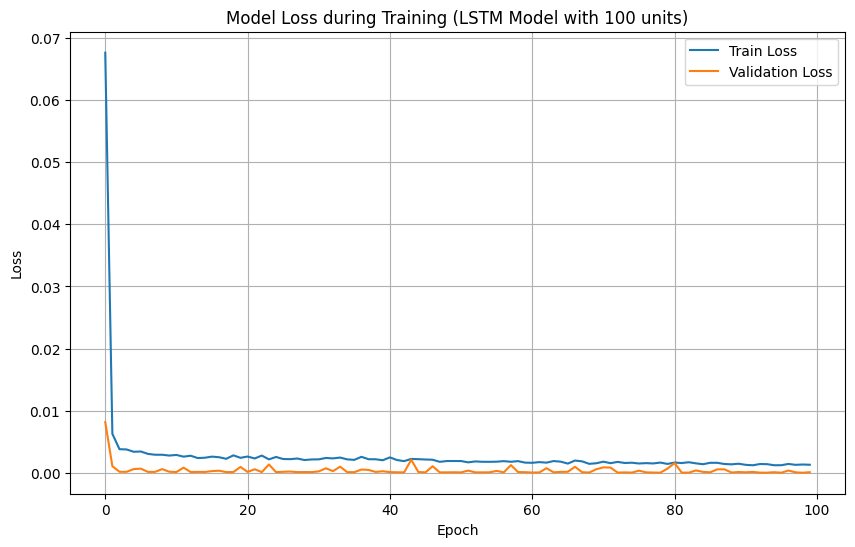

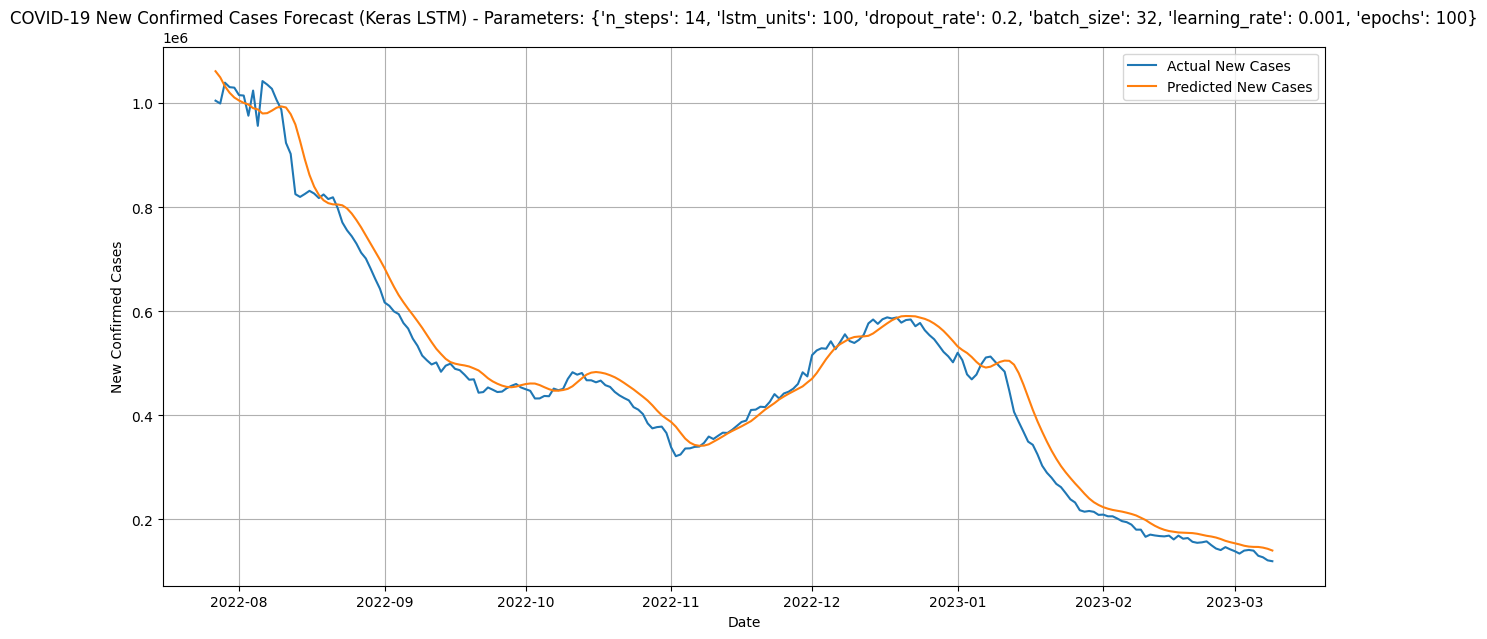

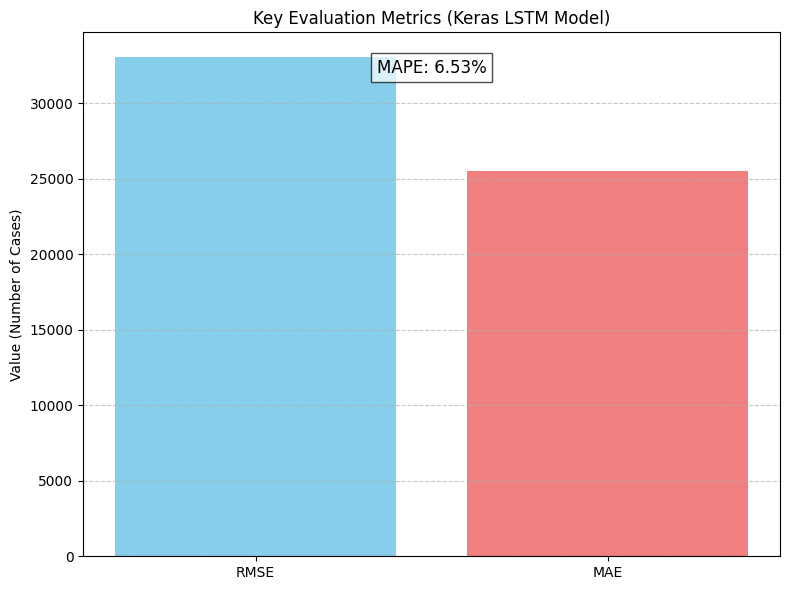


Forecasting next day using the trained model...
Predicted new confirmed cases for next day: 136545

--- Applying Quantization ---
Saved artifact at 'keras_lstm_model_original_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 14, 1), dtype=tf.float32, name='keras_tensor_32')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132741484559440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132741484558096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132741484556752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132741484556368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132741484560016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132744978146576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132741484550032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132744978143504: TensorSpec(shape=(), dtype=tf.resource, name=None)
Original

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import math
import warnings
import tensorflow as tf # Import TensorFlow
import os # For file operations

warnings.filterwarnings("ignore")

# ------------------------ GPU Configuration ------------------------ #
print("--- GPU Configuration ---")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs configured.")
        print("TensorFlow will attempt to use GPU(s) if available.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU devices found. TensorFlow will use CPU.")
print("------------------------\n")

# ------------------------ 1. Load & Preprocess Data ------------------------ #
# Load dataset
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df = pd.read_csv(url)

# Preprocess: sum across all countries to get global total
df_time_series = df.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long']).sum(axis=0)
df_time_series = pd.DataFrame(df_time_series, columns=['Confirmed'])
df_time_series.index = pd.to_datetime(df_time_series.index)

# Calculate new daily confirmed cases
df_time_series['New_Confirmed'] = df_time_series['Confirmed'].diff().fillna(0)
df_time_series['New_Confirmed'] = df_time_series['New_Confirmed'].apply(lambda x: max(0, x))

# Smooth the data with 7-day moving average
df_time_series['Smoothed'] = df_time_series['New_Confirmed'].rolling(7).mean().fillna(method='bfill')
df_time_series['Smoothed'] = df_time_series['Smoothed'].fillna(method='ffill') # Ensure no NaNs remain

# Log transform to reduce scale volatility
df_time_series['Log_Smoothed'] = np.log1p(df_time_series['Smoothed'])

# Scale data
scaler = MinMaxScaler()
# Reshape for scaler as fit_transform expects 2D array, then flatten for create_sequences
scaled_data = scaler.fit_transform(df_time_series['Log_Smoothed'].values.reshape(-1, 1)) # Keep 2D for create_sequences

# Create sequences function
def create_sequences(data, n_steps):
    """
    Creates sequences of data for LSTM input.
    X: sequences of 'n_steps' values
    y: the value immediately following the sequence
    Data should be 2D: (samples, features)
    """
    X, y = [], []
    for i in range(len(data) - n_steps):
        # Data here is 2D, so access the first (and only) feature
        X.append(data[i:i+n_steps, 0])
        y.append(data[i+n_steps, 0])
    return np.array(X), np.array(y)

# ------------------------ 2. Define Fixed Model Parameters ------------------------ #
# These parameters are now fixed, no tuning will be performed.
# You can adjust these values manually to experiment.
fixed_params = {
    'n_steps': 14,          # Look-back window size
    'lstm_units': 100,      # Number of LSTM units in each layer
    'dropout_rate': 0.2,    # Dropout rate
    'batch_size': 32,       # Training batch size
    'learning_rate': 0.001, # Learning rate for Adam optimizer
    'epochs': 100           # Number of training epochs (EarlyStopping will typically halt sooner)
}

n_steps = fixed_params['n_steps'] # Define n_steps in global scope for plots
lstm_units = fixed_params['lstm_units']
dropout_rate = fixed_params['dropout_rate']
batch_size = fixed_params['batch_size']
learning_rate = fixed_params['learning_rate']
epochs = fixed_params['epochs']


# ------------------------ 3. Create Sequences and Split Data ------------------------ #
X, y = create_sequences(scaled_data, n_steps)
X = X.reshape((X.shape[0], X.shape[1], 1)) # Reshape for LSTM input (samples, timesteps, features)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Data prepared: Train samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"LSTM input shape: {X_train.shape[1:]}") # Should be (n_steps, 1)

# ------------------------ 4. Build and Train LSTM Model ------------------------ #
print("\nBuilding and training LSTM model with fixed parameters...")
model = Sequential()
model.add(LSTM(lstm_units, return_sequences=True, input_shape=(n_steps, 1)))
model.add(Dropout(dropout_rate))
model.add(LSTM(lstm_units))
model.add(Dropout(dropout_rate))
model.add(Dense(1))

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

history = model.fit(X_train, y_train, epochs=epochs,
                    batch_size=batch_size, validation_split=0.1,
                    callbacks=[early_stop], verbose=1)

print("Model training complete.")

# ------------------------ 5. Make Predictions and Inverse Transform ------------------------ #
print("\nMaking predictions on the test set...")
predictions_scaled = model.predict(X_test, verbose=0)

# Inverse transform predictions and actual values back to original scale
predictions = np.expm1(scaler.inverse_transform(predictions_scaled))
y_test_original = np.expm1(scaler.inverse_transform(y_test.reshape(-1, 1)))

# Ensure predictions are non-negative
predictions[predictions < 0] = 0

# ------------------------ 6. Evaluation Metrics ------------------------ #
rmse = math.sqrt(mean_squared_error(y_test_original, predictions))
mae = mean_absolute_error(y_test_original, predictions)

valid_indices_mape = y_test_original > 1e-8
if np.any(valid_indices_mape):
    mape = np.mean(np.abs((y_test_original[valid_indices_mape] - predictions[valid_indices_mape]) / y_test_original[valid_indices_mape])) * 100
else:
    mape = float('inf')

print(f"\n✅ Evaluation Metrics (Keras LSTM Model):")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# ------------------------ 7. Plots ------------------------ #
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Model Loss during Training (LSTM Model with {lstm_units} units)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Visualize predictions
test_start_idx_in_original_series = len(df_time_series.index) - len(y_test_original)
test_dates = df_time_series.index[test_start_idx_in_original_series:]

plt.figure(figsize=(15, 7))
plt.plot(test_dates, y_test_original, label='Actual New Cases')
plt.plot(test_dates, predictions, label='Predicted New Cases')
plt.title(f'COVID-19 New Confirmed Cases Forecast (Keras LSTM) - Parameters: {fixed_params}')
plt.xlabel('Date')
plt.ylabel('New Confirmed Cases')
plt.legend()
plt.grid(True)
plt.show()

# Plot All Evaluation Measures
plt.figure(figsize=(8, 6))
metrics_labels = ['RMSE', 'MAE']
metrics_values = [rmse, mae]

x = np.arange(len(metrics_labels))
plt.bar(x, metrics_values, color=['skyblue', 'lightcoral'])
plt.xticks(x, metrics_labels)
plt.ylabel('Value (Number of Cases)')
plt.title('Key Evaluation Metrics (Keras LSTM Model)')

plt.text(0.5, 0.95, f'MAPE: {mape:.2f}%', horizontalalignment='center', verticalalignment='top',
         transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ------------------------ 8. Forecast Next Day ------------------------ #
print("\nForecasting next day using the trained model...")
final_n_steps = fixed_params['n_steps']

last_n_steps_sequence = scaled_data[-final_n_steps:].reshape(1, final_n_steps, 1)

next_day_scaled = model.predict(last_n_steps_sequence, verbose=0)

next_day_forecast = np.expm1(scaler.inverse_transform(next_day_scaled))
next_day_forecast = max(0, next_day_forecast[0][0])

print(f"Predicted new confirmed cases for next day: {next_day_forecast:.0f}")

# ------------------------ 9. Quantization and Memory Reduction ------------------------ #
print("\n--- Applying Quantization ---")
# Changed to a directory for SavedModel format
original_model_dir = "keras_lstm_model_original_savedmodel"
quantized_model_path = "keras_lstm_model_quantized.tflite"

# Save the original Keras model in SavedModel format
try:
    # Use model.export for SavedModel format (recommended for TFLite conversion)
    model.export(original_model_dir)
    # Calculate size of the directory
    original_size_bytes = sum(os.path.getsize(os.path.join(dirpath, filename)) for dirpath, dirnames, filenames in os.walk(original_model_dir) for filename in filenames)
    print(f"Original Keras model saved to '{original_model_dir}' directory. Size: {original_size_bytes / 1024:.2f} KB")
except Exception as e:
    print(f"Error saving original Keras model: {e}")
    original_size_bytes = 0 # Set to 0 if saving fails

# Convert the Keras model to TensorFlow Lite and apply dynamic range quantization
try:
    converter = tf.lite.TFLiteConverter.from_saved_model(original_model_dir)
    # Apply the experimental flags to handle LSTM issues
    converter.experimental_enable_resource_variables = True
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS, # Enable standard TFLite ops
        tf.lite.OpsSet.SELECT_TF_OPS    # Enable select TensorFlow ops (for operations not in TFLite built-ins)
    ]
    # This flag can help with lowering tensor list ops, which often cause issues with LSTMs
    converter._experimental_lower_tensor_list_ops = False
    converter.optimizations = [tf.lite.Optimize.DEFAULT] # Apply dynamic range quantization

    tflite_quantized_model = converter.convert()

    with open(quantized_model_path, 'wb') as f:
        f.write(tflite_quantized_model)

    quantized_size_bytes = os.path.getsize(quantized_model_path)
    print(f"Quantized TFLite model saved to '{quantized_model_path}'. Size: {quantized_size_bytes / 1024:.2f} KB")

    if original_size_bytes > 0:
        memory_reduction_percent = ((original_size_bytes - quantized_size_bytes) / original_size_bytes) * 100
        print(f"Memory Reduction: {memory_reduction_percent:.2f}%")
    else:
        print("Cannot calculate memory reduction as original model size is 0.")

except Exception as e:
    print(f"Error during TFLite conversion or quantization: {e}")
    print("Please ensure TensorFlow and TensorFlow Lite are correctly installed.")
print("----------------------------\n")


ARima


✅ Evaluation Metrics:
Root Mean Squared Error (RMSE): 203943.47
Mean Absolute Error (MAE): 177411.73
Mean Absolute Percentage Error (MAPE): 51.61%


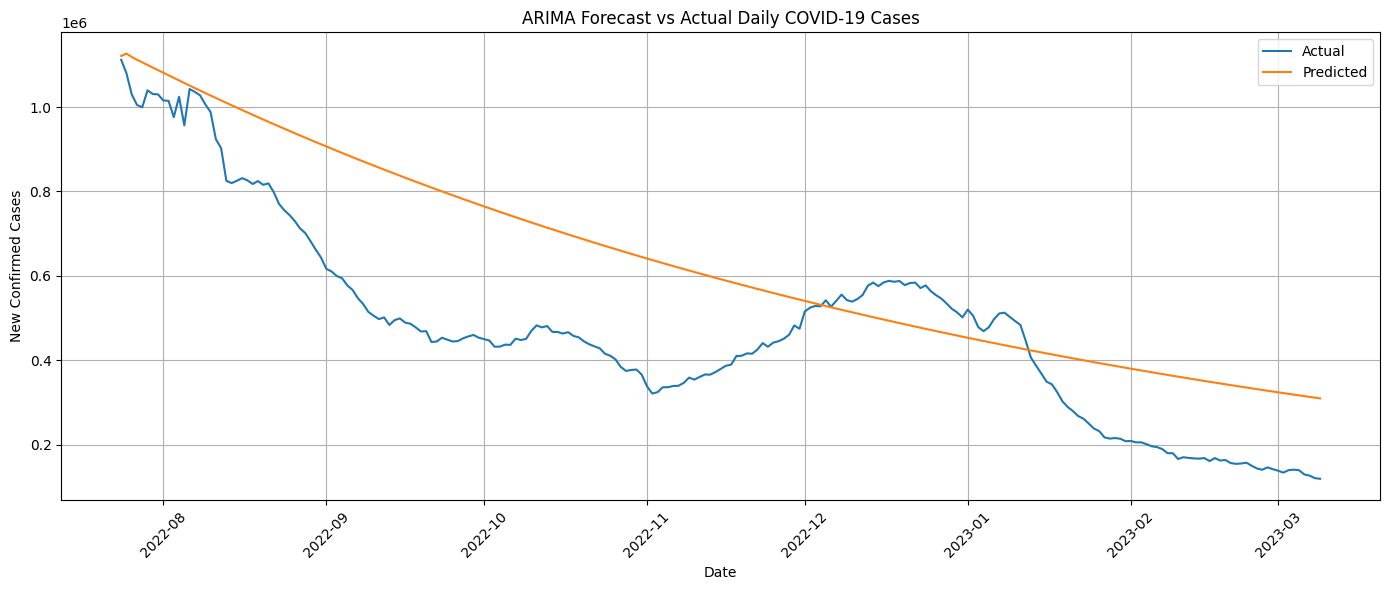

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

# ------------------------ 1. Load & Preprocess Data ------------------------ #
# Load COVID-19 data
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df = pd.read_csv(url)

# Aggregate global daily confirmed cases
df_time_series = df.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long']).sum(axis=0)
df_time_series = pd.DataFrame(df_time_series, columns=['Confirmed'])
df_time_series.index = pd.to_datetime(df_time_series.index)

# Compute new daily cases
df_time_series['New_Confirmed'] = df_time_series['Confirmed'].diff().fillna(0)
df_time_series['New_Confirmed'] = df_time_series['New_Confirmed'].apply(lambda x: max(0, x))

# Apply 7-day moving average smoothing
df_time_series['Smoothed'] = df_time_series['New_Confirmed'].rolling(window=7).mean().fillna(method='bfill')

# Use log transformation to stabilize variance
df_time_series['Log_Smoothed'] = np.log1p(df_time_series['Smoothed'])

# ------------------------ 2. Train/Test Split ------------------------ #
series = df_time_series['Log_Smoothed']
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# ------------------------ 3. Fit ARIMA Model ------------------------ #
# You can use auto_arima (from pmdarima) to find the best order, but here we hardcode for simplicity
order = (2, 2, 4)  # ARIMA(p,d,q)

model = ARIMA(train, order=order)
fitted_model = model.fit()

# ------------------------ 4. Forecast ------------------------ #
forecast_log = fitted_model.forecast(steps=len(test))
forecast = np.expm1(forecast_log)
actual = np.expm1(test)

# ------------------------ 5. Evaluation ------------------------ #
rmse = math.sqrt(mean_squared_error(actual, forecast))
mae = mean_absolute_error(actual, forecast)
mape = np.mean(np.abs((actual - forecast) / actual)) * 100

print(f"\n✅ Evaluation Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# ------------------------ 6. Plots ------------------------ #
# Actual vs. Predicted
plt.figure(figsize=(14, 6))
plt.plot(test.index, actual, label='Actual')
plt.plot(test.index, forecast, label='Predicted')
plt.title('ARIMA Forecast vs Actual Daily COVID-19 Cases')
plt.xlabel('Date')
plt.ylabel('New Confirmed Cases')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Searching for optimal non-seasonal ARIMA parameters (p, d, q) based on AIC...


p-order:   0%|          | 0/3 [00:00<?, ?it/s]

❗ No optimal order found, defaulting to (2, 2, 4).

Fitting final ARIMA model with optimized order=(2, 2, 4) on training data...

Model Summary:
                               SARIMAX Results                                
Dep. Variable:           Log_Smoothed   No. Observations:                  914
Model:                 ARIMA(2, 2, 4)   Log Likelihood                1612.654
Date:                Mon, 14 Jul 2025   AIC                          -3211.307
Time:                        12:52:15   BIC                          -3177.598
Sample:                    01-22-2020   HQIC                         -3198.438
                         - 07-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6692      0.038    -17.390      0.000      -0.74

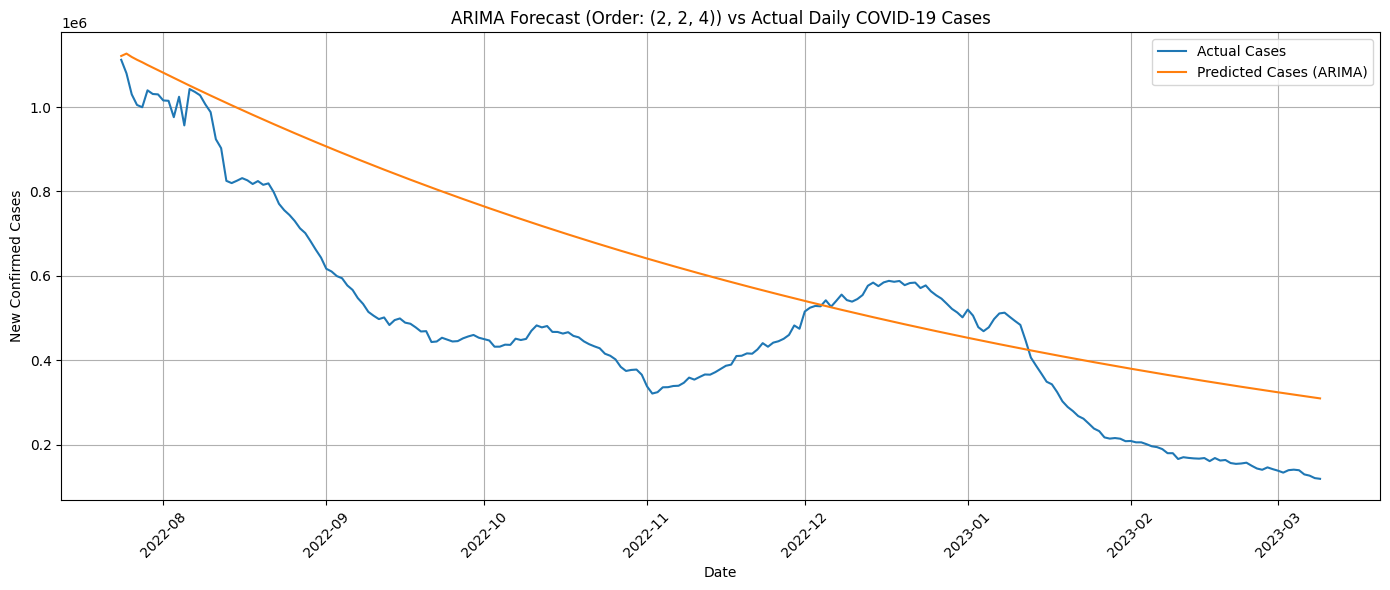


Forecasting next day using ARIMA model fitted on FULL historical data...
Predicted smoothed new confirmed cases for next day: 114421


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.tsa.arima.model import ARIMA
import warnings
from tqdm.notebook import tqdm # For displaying progress during grid search

warnings.filterwarnings("ignore")

# ------------------------ 1. Load & Preprocess Data ------------------------ #
# Load COVID-19 data
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df = pd.read_csv(url)

# Aggregate global daily confirmed cases
df_time_series = df.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long']).sum(axis=0)
df_time_series = pd.DataFrame(df_time_series, columns=['Confirmed'])
df_time_series.index = pd.to_datetime(df_time_series.index)

# Compute new daily cases
df_time_series['New_Confirmed'] = df_time_series['Confirmed'].diff().fillna(0)
df_time_series['New_Confirmed'] = df_time_series['New_Confirmed'].apply(lambda x: max(0, x))

# Apply 7-day moving average smoothing
df_time_series['Smoothed'] = df_time_series['New_Confirmed'].rolling(window=7).mean().fillna(method='bfill')
df_time_series['Smoothed'] = df_time_series['Smoothed'].fillna(method='ffill') # Ensure no NaNs remain

# Use log transformation to stabilize variance
df_time_series['Log_Smoothed'] = np.log1p(df_time_series['Smoothed'])

# ------------------------ 2. Train/Test Split ------------------------ #
series = df_time_series['Log_Smoothed']
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# ------------------------ 3. Optimize ARIMA Model Parameters (Grid Search) ------------------------ #
# Function to evaluate ARIMA model for a given order using AIC
def evaluate_arima_model(data, order):
    try:
        model = ARIMA(data, order=order)
        # Using disp=False to suppress convergence messages for each trial
        model_fit = model.fit(disp=False)
        return model_fit.aic
    except Exception:
        # If a model fails to fit (e.g., non-invertible, non-stationary parameters),
        # return a very large AIC to exclude it from being chosen as "best".
        return float('inf')

# Define ranges for p, d, q parameters for the grid search
# These ranges are common starting points; you can expand them if needed.
p_values = range(0, 3) # Autoregressive (AR) order
d_values = range(0, 3) # Differencing (I) order
q_values = range(0, 4) # Moving Average (MA) order

best_aic = float('inf') # Initialize with a very large value
best_order = None

print("Searching for optimal non-seasonal ARIMA parameters (p, d, q) based on AIC...")

# Perform grid search to find the best ARIMA order
for p in tqdm(p_values, desc="p-order"): # tqdm adds a progress bar for the outer loop
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            aic = evaluate_arima_model(train, order)

            # If the current model has a lower AIC, update the best parameters
            if aic < best_aic:
                best_aic = aic
                best_order = order
                # print(f"Found new best: ARIMA{order} - AIC: {aic:.2f}") # Uncomment to see search progress

# Fallback in case no valid model is found (highly unlikely with these ranges, but good practice)
if best_order is None:
    best_order = (2, 2, 4) # Default to your previously specified order if search fails
    print(f"❗ No optimal order found, defaulting to {best_order}.")
else:
    print(f"\n✅ Optimal non-seasonal ARIMA Order: {best_order} with AIC: {best_aic:.2f}")

# ------------------------ 4. Fit Final ARIMA Model with Optimized Order ------------------------ #
fitted_model = None
print(f"\nFitting final ARIMA model with optimized order={best_order} on training data...")
try:
    model = ARIMA(train, order=best_order)
    fitted_model = model.fit()
    print("\nModel Summary:")
    print(fitted_model.summary()) # Print summary for detailed model diagnostics
except Exception as e:
    print(f"❗ Error fitting final ARIMA model: {e}")

# ------------------------ 5. Forecast ------------------------ #
forecast = np.array([])
actual = np.array([])

if fitted_model:
    # Forecast steps equal to the length of the test set
    forecast_log = fitted_model.forecast(steps=len(test))
    forecast = np.expm1(forecast_log) # Inverse log transform
    actual = np.expm1(test) # Inverse log transform the actual test data

    # Ensure predictions are non-negative, as cases cannot be negative
    forecast[forecast < 0] = 0
else:
    # If model fitting failed, populate with zeros to prevent errors in subsequent steps
    forecast = np.zeros_like(test)
    actual = np.expm1(test) # Still get actuals for plotting even if forecast is zero

# ------------------------ 6. Evaluation ------------------------ #
if len(actual) > 0 and len(forecast) > 0:
    # Calculate evaluation metrics
    rmse = math.sqrt(mean_squared_error(actual, forecast))
    mae = mean_absolute_error(actual, forecast)

    # MAPE calculation: Handle potential division by zero or very small actual values
    # Filter out actual values that are zero or very close to zero to avoid infinite MAPE
    valid_indices = actual > 1e-8 # Use a small epsilon to avoid division by zero
    if np.any(valid_indices):
        mape = np.mean(np.abs((actual[valid_indices] - forecast[valid_indices]) / actual[valid_indices])) * 100
    else:
        mape = float('inf') # If all actual values are zero/near-zero, MAPE is not meaningful

    print(f"\n✅ Evaluation Metrics (for ARIMA{best_order}):")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
else:
    print("\n❗ Model fitting or forecasting failed, cannot compute evaluation metrics.")

# ------------------------ 7. Plots ------------------------ #
# Actual vs. Predicted
plt.figure(figsize=(14, 6))
plt.plot(test.index, actual, label='Actual Cases')
plt.plot(test.index, forecast, label='Predicted Cases (ARIMA)')
plt.title(f'ARIMA Forecast (Order: {best_order}) vs Actual Daily COVID-19 Cases')
plt.xlabel('Date')
plt.ylabel('New Confirmed Cases')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------ 8. Forecast Next Day ------------------------ #
# To forecast the very next day, it's best practice to fit the model on the full historical series
print("\nForecasting next day using ARIMA model fitted on FULL historical data...")
next_day_forecast = 0
try:
    full_model = ARIMA(series, order=best_order)
    full_fitted_model = full_model.fit()
    next_day_log_forecast = full_fitted_model.forecast(steps=1)
    next_day_forecast = np.expm1(next_day_log_forecast.iloc[0]) # Inverse log transform
    next_day_forecast = max(0, next_day_forecast) # Ensure non-negative forecast
except Exception as e:
    print(f"❗ Error forecasting next day: {e}")
    next_day_forecast = 0 # Default to 0 on error

print(f"Predicted smoothed new confirmed cases for next day: {next_day_forecast:.0f}")


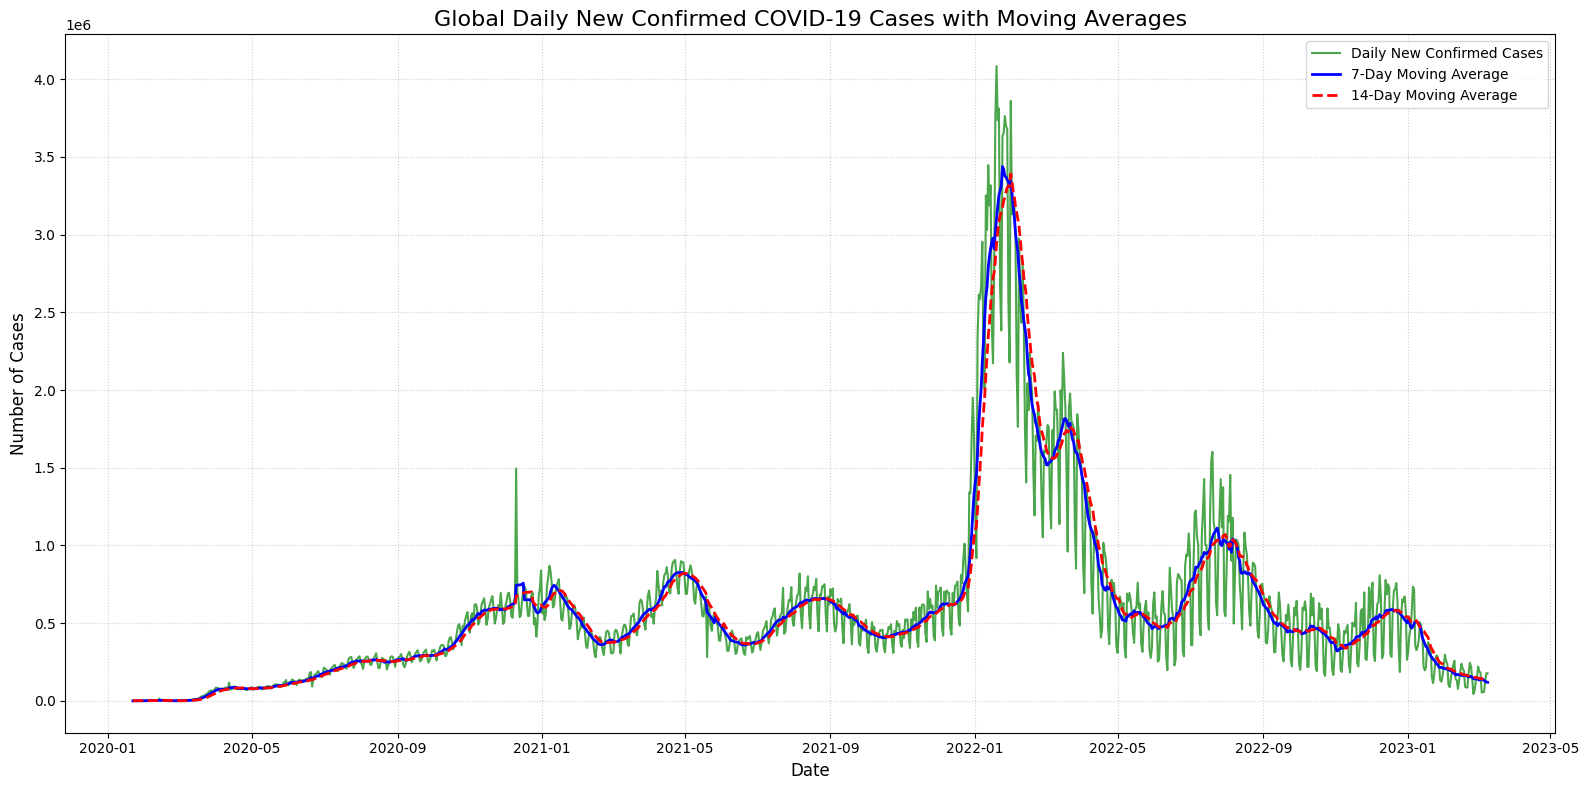

Moving Averages calculation and visualization complete. The plot shows the raw daily new cases alongside their 7-day and 14-day moving averages.
The moving averages help to smooth out daily fluctuations and reveal underlying trends.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------ 1. Load Data ------------------------ #
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df = pd.read_csv(url)

# ------------------------ 2. Preprocess Data ------------------------ #
# Aggregate confirmed cases globally by summing across all countries/regions
# Drop identifying columns and sum rows (axis=0 for columns as time series are columns)
df_time_series = df.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long']).sum(axis=0)

# Convert the Series to a DataFrame with a 'Confirmed' column
df_time_series = pd.DataFrame(df_time_series, columns=['Confirmed'])

# Convert index to datetime objects for time series plotting
df_time_series.index = pd.to_datetime(df_time_series.index)

# Calculate new daily confirmed cases
# .diff() calculates the difference between current and previous row
# .fillna(0) handles the first day which would be NaN after diff()
df_time_series['New_Confirmed'] = df_time_series['Confirmed'].diff().fillna(0)

# Ensure new confirmed cases are non-negative, as sometimes data corrections can lead to negative values
df_time_series['New_Confirmed'] = df_time_series['New_Confirmed'].apply(lambda x: max(0, x))

# ------------------------ 3. Calculate Moving Averages ------------------------ #
# Calculate a 7-day Simple Moving Average (SMA)
# .rolling(window=7) creates a rolling window of 7 days
# .mean() calculates the mean within that window
# .fillna(method='bfill') fills the initial NaN values (first 6 days) using the next valid observation
df_time_series['SMA_7_Day'] = df_time_series['New_Confirmed'].rolling(window=7).mean().fillna(method='bfill')

# Calculate a 14-day Simple Moving Average (SMA) for longer trend visualization
df_time_series['SMA_14_Day'] = df_time_series['New_Confirmed'].rolling(window=14).mean().fillna(method='bfill')

# For the remaining few NaNs at the very beginning (if any, due to bfill not reaching), ffill them
df_time_series['SMA_7_Day'] = df_time_series['SMA_7_Day'].fillna(method='ffill')
df_time_series['SMA_14_Day'] = df_time_series['SMA_14_Day'].fillna(method='ffill')

# ------------------------ 4. Plotting ------------------------ #
plt.figure(figsize=(16, 8))

# Plot the raw new confirmed cases
plt.plot(df_time_series.index, df_time_series['New_Confirmed'],
         label='Daily New Confirmed Cases', color='green', alpha=0.7)

# Plot the 7-day moving average
plt.plot(df_time_series.index, df_time_series['SMA_7_Day'],
         label='7-Day Moving Average', color='blue', linewidth=2)

# Plot the 14-day moving average
plt.plot(df_time_series.index, df_time_series['SMA_14_Day'],
         label='14-Day Moving Average', color='red', linewidth=2, linestyle='--')


plt.title('Global Daily New Confirmed COVID-19 Cases with Moving Averages', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Cases', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

print("Moving Averages calculation and visualization complete. The plot shows the raw daily new cases alongside their 7-day and 14-day moving averages.")
print("The moving averages help to smooth out daily fluctuations and reveal underlying trends.")


Fitting Prophet model to smoothed data...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfpaex0g5/dowxqq0_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfpaex0g5/epmoc57l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18829', 'data', 'file=/tmp/tmpfpaex0g5/dowxqq0_.json', 'init=/tmp/tmpfpaex0g5/epmoc57l.json', 'output', 'file=/tmp/tmpfpaex0g5/prophet_modelljumolyh/prophet_model-20250714125219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:52:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:52:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet model fitting complete.

✅ Evaluation Metrics (for Prophet on Smoothed Data):
Root Mean Squared Error (RMSE): 898976.33
Mean Squared Error (MSE): 808158437844.92
Mean Absolute Error (MAE): 845259.98
Mean Absolute Percentage Error (MAPE): 280.84%


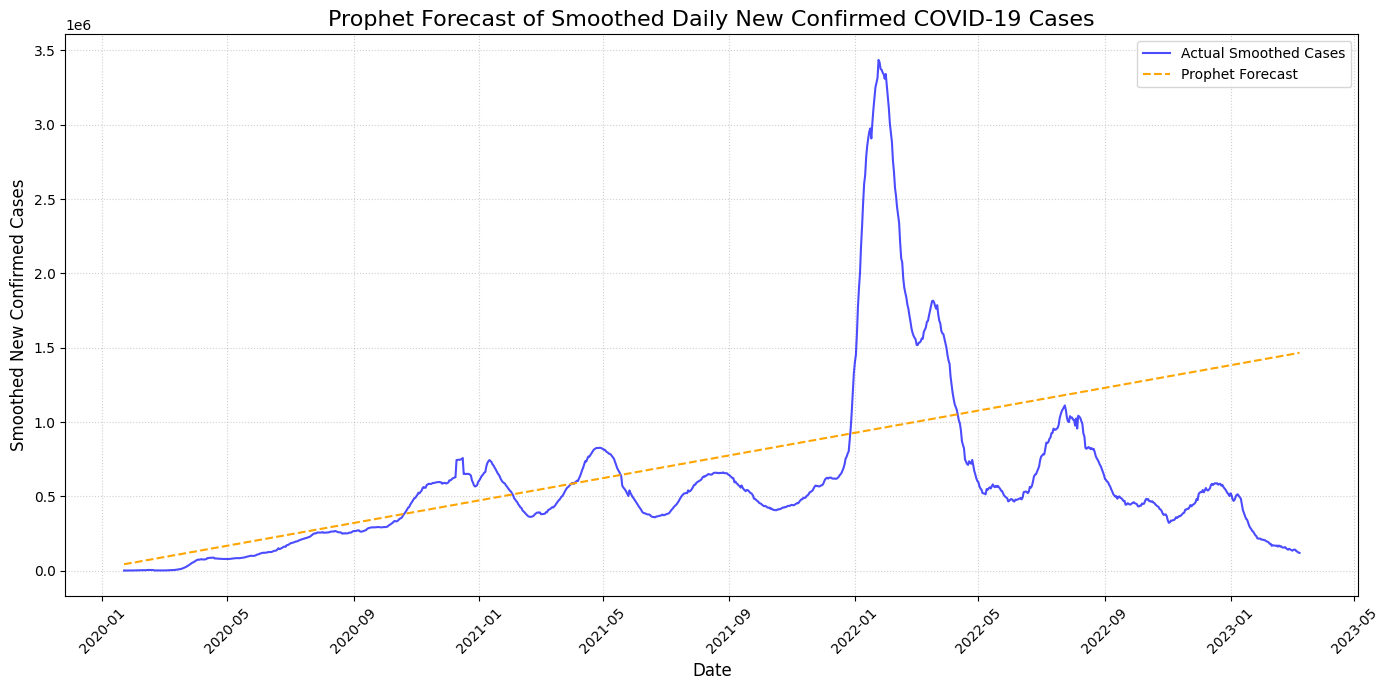

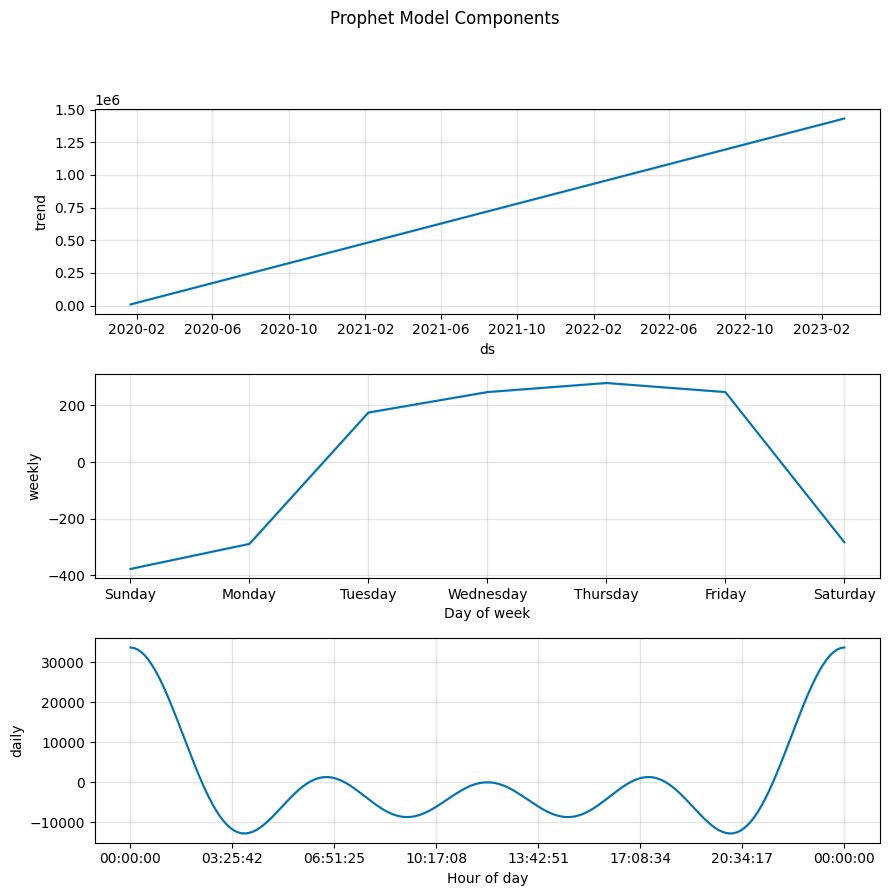

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet # The Prophet library
from sklearn.metrics import mean_squared_error, mean_absolute_error , mean_squared_error
import math
import warnings

warnings.filterwarnings("ignore") # Suppress warnings

# ------------------------ 1. Load & Preprocess Data ------------------------ #
# Load COVID-19 data
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df = pd.read_csv(url)

# Aggregate global daily confirmed cases
df_time_series = df.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long']).sum(axis=0)
df_time_series = pd.DataFrame(df_time_series, columns=['Confirmed'])
df_time_series.index = pd.to_datetime(df_time_series.index)

# Compute new daily cases
df_time_series['New_Confirmed'] = df_time_series['Confirmed'].diff().fillna(0)
df_time_series['New_Confirmed'] = df_time_series['New_Confirmed'].apply(lambda x: max(0, x))

# Apply 7-day moving average smoothing (this is the series Prophet will model)
df_time_series['Smoothed'] = df_time_series['New_Confirmed'].rolling(window=7).mean().fillna(method='bfill')
df_time_series['Smoothed'] = df_time_series['Smoothed'].fillna(method='ffill') # Ensure no NaNs remain

# ------------------------ 2. Prepare Data for Prophet ------------------------ #
# Prophet requires the dataframe to have two specific columns: 'ds' (datetime) and 'y' (numerical value)
prophet_df = df_time_series[['Smoothed']].reset_index()
prophet_df.rename(columns={'index': 'ds', 'Smoothed': 'y'}, inplace=True)

# ------------------------ 3. Train/Test Split for Prophet ------------------------ #
train_size = int(len(prophet_df) * 0.8)
train_prophet_df = prophet_df.iloc[:train_size]
test_prophet_df = prophet_df.iloc[train_size:]

# ------------------------ 4. Fit Prophet Model ------------------------ #
print("Fitting Prophet model to smoothed data...")
# Initialize Prophet model
# daily_seasonality=True is good for daily data like this
# changepoint_prior_scale can be adjusted to make the trend more or less flexible
m = Prophet(daily_seasonality=True,
            weekly_seasonality=True, # Often present in COVID-19 reporting
            yearly_seasonality=False, # Likely not relevant for this dataset's length/nature
            changepoint_prior_scale=0.001 # Default is 0.05, try tuning for more/less flexible trend
           )

# Fit the model to the training data
m.fit(train_prophet_df)
print("Prophet model fitting complete.")

# ------------------------ 5. Make Future DataFrame and Forecast ------------------------ #
# Create a DataFrame with future dates for forecasting
# We want to forecast for the length of our test set
future = m.make_future_dataframe(periods=len(test_prophet_df), include_history=True) # include_history to get in-sample predictions as well

# Make predictions
forecast_prophet = m.predict(future)

# ------------------------ 6. Extract Predictions for Evaluation ------------------------ #
# Align actual and predicted values for the test period
# Prophet's forecast dataframe contains 'yhat' (the prediction) and 'ds' (date)
# We need to filter forecast_prophet to only include the test period dates
forecast_test_period = forecast_prophet[forecast_prophet['ds'].isin(test_prophet_df['ds'])]
actual_test_period = test_prophet_df['y']
predicted_test_period = forecast_test_period['yhat']

# Ensure predictions are non-negative, as cases cannot be negative
predicted_test_period[predicted_test_period < 0] = 0

# ------------------------ 7. Evaluation ------------------------ #
# Calculate evaluation metrics
if len(actual_test_period) > 0 and len(predicted_test_period) > 0:
    rmse = math.sqrt(mean_squared_error(actual_test_period, predicted_test_period))
    mae = mean_absolute_error(actual_test_period, predicted_test_period)
    mse = mean_squared_error(actual_test_period, predicted_test_period )
    # MAPE calculation: Handle potential division by zero or very small actual values
    valid_indices = actual_test_period > 1e-8 # Use a small epsilon to avoid division by zero
    if np.any(valid_indices):
        mape = np.mean(np.abs((actual_test_period[valid_indices] - predicted_test_period[valid_indices]) / actual_test_period[valid_indices])) * 100
    else:
        mape = float('inf') # If all actual values are zero/near-zero, MAPE is not meaningful

    print(f"\n✅ Evaluation Metrics (for Prophet on Smoothed Data):")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
else:
    print("\n❗ Prophet model fitting or forecasting failed, cannot compute evaluation metrics.")

# ------------------------ 8. Plots ------------------------ #
plt.figure(figsize=(14, 7))

# Plot actual smoothed data
plt.plot(df_time_series.index, df_time_series['Smoothed'], label='Actual Smoothed Cases', color='blue', alpha=0.7)

# Plot Prophet's forecast (yhat) for the entire period, including historical data it fitted
# Use the 'forecast_prophet' DataFrame that includes both history and future
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Prophet Forecast', color='orange', linestyle='--')

# Highlight the test period explicitly if desired
# plt.plot(test_prophet_df['ds'], predicted_test_period, label='Prophet Predicted Test', color='red', linestyle=':')


plt.title('Prophet Forecast of Smoothed Daily New Confirmed COVID-19 Cases', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Smoothed New Confirmed Cases', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show Prophet components
# Prophet can also plot its components (trend, weekly seasonality, daily seasonality)
fig = m.plot_components(forecast_prophet)
plt.suptitle('Prophet Model Components', y=1.02) # Adjust suptitle position
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam # Import Adam optimizer to control learning rate
import math
import itertools # For generating combinations of hyperparameters
import warnings

warnings.filterwarnings("ignore") # Suppress warnings for cleaner output

# ------------------------ 1. Load & Preprocess Data ------------------------ #
# Load dataset
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df = pd.read_csv(url)

# Preprocess: sum across all countries to get global total
df_time_series = df.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long']).sum(axis=0)
df_time_series = pd.DataFrame(df_time_series, columns=['Confirmed'])
df_time_series.index = pd.to_datetime(df_time_series.index)

# Calculate new daily confirmed cases
df_time_series['New_Confirmed'] = df_time_series['Confirmed'].diff().fillna(0)
df_time_series['New_Confirmed'] = df_time_series['New_Confirmed'].apply(lambda x: max(0, x))

# Smooth the data with 7-day moving average
df_time_series['Smoothed'] = df_time_series['New_Confirmed'].rolling(7).mean().fillna(method='bfill')
df_time_series['Smoothed'] = df_time_series['Smoothed'].fillna(method='ffill') # Ensure no NaNs remain

# Log transform to reduce scale volatility
df_time_series['Log_Smoothed'] = np.log1p(df_time_series['Smoothed'])

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_time_series['Log_Smoothed'].values.reshape(-1, 1))

# Create sequences function remains the same
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps, 0])
        y.append(data[i+n_steps, 0])
    return np.array(X), np.array(y)

# ------------------------ 2. Hyperparameter Grid Definition ------------------------ #
# Define the hyperparameters and their values to test
hyperparameters = {
    'n_steps': [7, 14, 21], # Look-back window
    'lstm_units': [50, 100, 150], # Number of LSTM units in each layer
    'dropout_rate': [0.1, 0.2, 0.3], # Dropout rate after LSTM layers
    'batch_size': [16, 32, 64], # Batch size for training
    'learning_rate': [0.001, 0.0005] # Learning rate for Adam optimizer
}

# Generate all combinations of hyperparameters
keys = list(hyperparameters.keys())
combinations = list(itertools.product(*hyperparameters.values()))

# Store results for each combination
best_rmse = float('inf')
best_params = None
all_results = []

# ------------------------ 3. Function to Build and Train Model ------------------------ #
def build_and_train_lstm(n_steps, lstm_units, dropout_rate, batch_size, learning_rate,
                         X_train_data, y_train_data, X_test_data, y_test_data, scaler_obj):
    """
    Builds, compiles, trains, and evaluates an LSTM model with given hyperparameters.
    """
    # Create sequences based on current n_steps
    X_seq, y_seq = create_sequences(scaled_data, n_steps)
    X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))

    # Re-split data based on new sequences (train_size remains fixed percentage of original data points)
    # The number of sequence will change with n_steps.
    current_train_size = int(len(X_seq) * 0.8)
    X_train_current, X_test_current = X_seq[:current_train_size], X_seq[current_train_size:]
    y_train_current, y_test_current = y_seq[:current_train_size], y_seq[current_train_size:]

    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=(n_steps, 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    history = model.fit(X_train_current, y_train_current, epochs=300, # Reduced epochs for faster tuning, EarlyStopping will manage
                        batch_size=batch_size, validation_split=0.1,
                        callbacks=[early_stop], verbose=0) # verbose=0 to suppress output during tuning

    # Make predictions
    predictions_scaled = model.predict(X_test_current, verbose=0)

    # Inverse transform
    predictions = np.expm1(scaler_obj.inverse_transform(predictions_scaled))
    y_test_original = np.expm1(scaler_obj.inverse_transform(y_test_current.reshape(-1, 1)))

    # Ensure predictions are non-negative
    predictions[predictions < 0] = 0

    # Evaluation metrics
    rmse = math.sqrt(mean_squared_error(y_test_original, predictions))
    mae = mean_absolute_error(y_test_original, predictions)

    # Handle MAPE for potential division by zero
    valid_indices_mape = y_test_original > 1e-8
    if np.any(valid_indices_mape):
        mape = np.mean(np.abs((y_test_original[valid_indices_mape] - predictions[valid_indices_mape]) / y_test_original[valid_indices_mape])) * 100
    else:
        mape = float('inf') # If all actuals are zero, MAPE is not meaningful

    return rmse, mae, mape, model, X_test_current, y_test_original, predictions, history

# ------------------------ 4. Hyperparameter Tuning Loop ------------------------ #
print(f"Starting hyperparameter tuning for LSTM model. Total combinations: {len(combinations)}\n")

for i, combo in enumerate(combinations):
    current_params = dict(zip(keys, combo))
    print(f"--- Running combination {i+1}/{len(combinations)}: {current_params} ---")

    rmse, mae, mape, model_trained, X_test_final, y_test_original_final, predictions_final, history_final = \
        build_and_train_lstm(
            n_steps=current_params['n_steps'],
            lstm_units=current_params['lstm_units'],
            dropout_rate=current_params['dropout_rate'],
            batch_size=current_params['batch_size'],
            learning_rate=current_params['learning_rate'],
            X_train_data=None, # Not used directly in the function's internal data split
            y_train_data=None, # Not used directly
            X_test_data=None, # Not used directly
            y_test_data=None, # Not used directly
            scaler_obj=scaler # Pass the original scaler
        )

    print(f"  RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")

    all_results.append({
        'params': current_params,
        'rmse': rmse,
        'mae': mae,
        'mape': mape
    })

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = current_params
        best_model = model_trained # Store the best model
        best_X_test = X_test_final
        best_y_test_original = y_test_original_final
        best_predictions = predictions_final
        best_history = history_final

print("\n------------------------ Tuning Complete ------------------------")
print(f"✅ Best Hyperparameters Found: {best_params}")
print(f"✅ Best RMSE: {best_rmse:.2f}")

# ------------------------ 5. Final Evaluation and Plots for Best Model ------------------------ #
if best_params:
    print(f"\nDisplaying results for the best model with parameters: {best_params}")

    # Evaluation metrics for the best model
    rmse = math.sqrt(mean_squared_error(best_y_test_original, best_predictions))
    mae = mean_absolute_error(best_y_test_original, best_predictions)

    valid_indices_mape = best_y_test_original > 1e-8
    if np.any(valid_indices_mape):
        mape = np.mean(np.abs((best_y_test_original[valid_indices_mape] - best_predictions[valid_indices_mape]) / best_y_test_original[valid_indices_mape])) * 100
    else:
        mape = float('inf')

    print(f"\n✅ Final Evaluation Metrics (Best LSTM Model):")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

    # Plot training history for the best model
    plt.figure(figsize=(10, 6))
    plt.plot(best_history.history['loss'], label='Train Loss')
    plt.plot(best_history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss during Training (Best LSTM Model with {best_params["lstm_units"]} units)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Visualize predictions for the best model
    # Re-calculate test_dates correctly as it depends on n_steps and train_size
    # Note: df_time_series.index is the original full date index
    # len(X_seq) is the number of sequences formed from the scaled_data with the best n_steps
    # current_train_size is 80% of len(X_seq)
    # The test dates for the best model's predictions start from the end of the current_train_size sequences

    # Calculate the start index for test_dates based on the best n_steps and the split
    original_data_start_index = df_time_series.index.get_loc(df_time_series.index[n_steps]) # Start after initial n_steps days
    # The test data's actual dates start from (original_data_start_index + number of train sequences)

    # Correctly map back the test predictions to their original dates
    # The indices of y_test_original_final correspond to the dates from the original series
    # after skipping the initial n_steps and the training portion.

    # Find the starting index in the original df_time_series.index for the test_data
    # The X_seq starts from df_time_series.index[n_steps]
    # The train_size of X_seq takes `current_train_size` elements
    # So the test_data starts from `current_train_size` + `n_steps` index in df_time_series.index (approximately)

    test_start_idx_in_original_series = len(df_time_series) - len(best_y_test_original)
    test_dates_best_model = df_time_series.index[test_start_idx_in_original_series:]


    plt.figure(figsize=(15, 7))
    plt.plot(test_dates_best_model, best_y_test_original, label='Actual New Cases')
    plt.plot(test_dates_best_model, best_predictions, label='Predicted New Cases')
    plt.title(f'COVID-19 New Confirmed Cases Forecast (LSTM) with Best Params: {best_params}')
    plt.xlabel('Date')
    plt.ylabel('New Confirmed Cases')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Forecast next day using the best model
    # Need to create the last sequence using the *full* scaled_data
    final_n_steps = best_params['n_steps']
    last_n_steps_sequence = scaled_data[-final_n_steps:].reshape(1, final_n_steps, 1)
    next_day_scaled = best_model.predict(last_n_steps_sequence, verbose=0)
    next_day = np.expm1(scaler.inverse_transform(next_day_scaled))
    print(f"Predicted new confirmed cases for next day (Best Model): {next_day[0][0]:.0f}")
else:
    print("❗ No best model found during tuning process.")



Starting hyperparameter tuning for LSTM model. Total combinations: 162

--- Running combination 1/162: {'n_steps': 7, 'lstm_units': 50, 'dropout_rate': 0.1, 'batch_size': 16, 'learning_rate': 0.001} ---
  RMSE: 22333.84, MAE: 15131.03, MAPE: 3.07%
--- Running combination 2/162: {'n_steps': 7, 'lstm_units': 50, 'dropout_rate': 0.1, 'batch_size': 16, 'learning_rate': 0.0005} ---
  RMSE: 47323.21, MAE: 35865.33, MAPE: 8.50%
--- Running combination 3/162: {'n_steps': 7, 'lstm_units': 50, 'dropout_rate': 0.1, 'batch_size': 32, 'learning_rate': 0.001} ---


  RMSE: 49707.58, MAE: 38012.81, MAPE: 9.20%
--- Running combination 4/162: {'n_steps': 7, 'lstm_units': 50, 'dropout_rate': 0.1, 'batch_size': 32, 'learning_rate': 0.0005} ---


  RMSE: 47615.79, MAE: 35700.76, MAPE: 8.24%
--- Running combination 5/162: {'n_steps': 7, 'lstm_units': 50, 'dropout_rate': 0.1, 'batch_size': 64, 'learning_rate': 0.001} ---
  RMSE: 46019.68, MAE: 35516.57, MAPE: 8.89%
--- Running combination 6/162: {'n_steps': 7, 'lstm_units': 50, 'dropout_rate': 0.1, 'batch_size': 64, 'learning_rate': 0.0005} ---
  RMSE: 50904.80, MAE: 37816.60, MAPE: 8.55%
--- Running combination 7/162: {'n_steps': 7, 'lstm_units': 50, 'dropout_rate': 0.2, 'batch_size': 16, 'learning_rate': 0.001} ---
  RMSE: 30228.88, MAE: 20468.17, MAPE: 4.02%
--- Running combination 8/162: {'n_steps': 7, 'lstm_units': 50, 'dropout_rate': 0.2, 'batch_size': 16, 'learning_rate': 0.0005} ---
  RMSE: 46173.12, MAE: 35940.24, MAPE: 9.25%
--- Running combination 9/162: {'n_steps': 7, 'lstm_units': 50, 'dropout_rate': 0.2, 'batch_size': 32, 'learning_rate': 0.001} ---
  RMSE: 42757.04, MAE: 33389.80, MAPE: 8.70%
--- Running combination 10/162: {'n_steps': 7, 'lstm_units': 50, 'dropout

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import math
from tensorflow.keras.optimizers import Adam
# Load dataset
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df = pd.read_csv(url)

# Preprocess: sum across all countries to get global total
df_time_series = df.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long']).sum(axis=0)
df_time_series = pd.DataFrame(df_time_series, columns=['Confirmed'])
df_time_series.index = pd.to_datetime(df_time_series.index)

# Calculate new daily confirmed cases
df_time_series['New_Confirmed'] = df_time_series['Confirmed'].diff().fillna(0)
df_time_series['New_Confirmed'] = df_time_series['New_Confirmed'].apply(lambda x: max(0, x))

# Smooth the data with 7-day moving average
df_time_series['Smoothed'] = df_time_series['New_Confirmed'].rolling(7).mean().fillna(method='bfill')

# Log transform to reduce scale volatility
df_time_series['Log_Smoothed'] = np.log1p(df_time_series['Smoothed'])

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_time_series['Log_Smoothed'].values.reshape(-1, 1))

# Create sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps, 0])
        y.append(data[i+n_steps, 0])
    return np.array(X), np.array(y)

n_steps = 14
X, y = create_sequences(scaled_data, n_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(n_steps, 1)))
model.add(Dropout(0.1))
model.add(LSTM(100))
model.add(Dropout(0.1))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.05)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=300, batch_size=16,
                    validation_split=0.1, callbacks=[early_stop], verbose=1)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
predictions_scaled = model.predict(X_test)

# Inverse transform (log1p + scaler)
predictions = np.expm1(scaler.inverse_transform(predictions_scaled))
y_test_original = np.expm1(scaler.inverse_transform(y_test.reshape(-1, 1)))

# Evaluation metrics
rmse = math.sqrt(mean_squared_error(y_test_original, predictions))
mae = mean_absolute_error(y_test_original, predictions)
mape = np.mean(np.abs((y_test_original - predictions) / y_test_original)) * 100

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Visualize predictions
test_dates = df_time_series.index[n_steps + train_size:]
plt.figure(figsize=(15, 7))
plt.plot(test_dates, y_test_original, label='Actual New Cases')
plt.plot(test_dates, predictions, label='Predicted New Cases')
plt.title('COVID-19 New Confirmed Cases Forecast (LSTM)')
plt.xlabel('Date')
plt.ylabel('New Confirmed Cases')
plt.legend()
plt.grid(True)
plt.show()

# Forecast next day
last_n_steps = scaled_data[-n_steps:].reshape(1, n_steps, 1)
next_day_scaled = model.predict(last_n_steps)
next_day = np.expm1(scaler.inverse_transform(next_day_scaled))
print(f"Predicted new confirmed cases for next day: {next_day[0][0]:.0f}")

